# Восстановление золота из руды

## Подготовка данных

Импортируем все необходимые модели, функции и библиотеки:

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import optuna 

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler 
from sklearn.utils import shuffle
from sklearn.metrics import make_scorer, mean_absolute_error

from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet

pd.set_option('display.max_columns', 500)

### Загрузка и изучение исходных данных

In [2]:
data_full = pd.read_csv('/datasets/gold_recovery_full_new.csv')
data_train = pd.read_csv('/datasets/gold_recovery_train_new.csv')
data_test = pd.read_csv('/datasets/gold_recovery_test_new.csv')

In [3]:
data_full.shape

(19439, 87)

In [4]:
data_train.shape # размер трейна

(14149, 87)

In [5]:
data_test.shape # размер тестовой выборки

(5290, 53)

Соотношение заданных тренировочной и тестовой выборок:

In [6]:
data_train.shape[0] / data_test.shape[0]

2.6746691871455575

In [7]:
data_full.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


In [8]:
data_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [9]:
data_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [10]:
data_full.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,19438.000000,19438.000000,19228.000000,19439.000000,19439.000000,19438.000000,19338.000000,19433.000000,19439.000000,19415.000000,19402.000000,19439.000000,19335.000000,19439.000000,19323.000000,19069.000000,19439.000000,19435.000000,19418.000000,19377.000000,19439.000000,1.943500e+04,19438.000000,1.943500e+04,19438.000000,1.943700e+04,19438.000000,1.943600e+04,19438.000000,1.943700e+04,19437.000000,19437.000000,19439.000000,19439.000000,19339.000000,19428.000000,19294.000000,19340.000000,19439.000000,19405.000000,19431.000000,19395.000000,18986.000000,19439.000000,19439.000000,19416.000000,19439.000000,19439.000000,19438.000000,19439.000000,19439.000000,19439.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19439.000000,19439.000000,19003.000000,19439.000000,19439.000000,19439.000000,19437.000000,19427.000000,17691.000000,19439.000000,19219.000000,19438.000000,19416.000000,19438.000000,19426.000000,19438.000000,19438.000000,19438.000000,19433.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438.000000,19438

In [11]:
data_full.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [12]:
data_train.describe()

,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14148.000000,14148.000000,13938.000000,14149.000000,14149.000000,14149.000000,14049.000000,14144.000000,14149.000000,14129.000000,14117.000000,14149.000000,14049.000000,14149.000000,14063.000000,13863.000000,14149.000000,14148.000000,14134.000000,14103.000000,14149.000000,14145.000000,14148.000000,14145.000000,14148.000000,14147.000000,14148.000000,14146.000000,14148.000000,1.414800e+04,14148.000000,14148.000000,14149.000000,14149.000000,14049.000000,14141.000000,14005.000000,14071.000000,14149.000000,14120.000000,14141.000000,14113.000000,13721.000000,14149.000000,14149.000000,14127.000000,14149.000000,14149.000000,14148.000000,14149.000000,14149.000000,14149.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14149.000000,14149.000000,13713.000000,14149.000000,14149.000000,14149.000000,14147.000000,14139.000000,12544.000000,14149.000000,13932.000000,14148.000000,14128.000000,14148.000000,14145.000000,14148.000000,14148.000000,14148.000000,14143.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148.000000,14148

In [13]:
data_train.head()

,date,final.output.concentrate_ag,final.output.concentrate_pb,final.output.concentrate_sol,final.output.concentrate_au,final.output.recovery,final.output.tail_ag,final.output.tail_pb,final.output.tail_sol,final.output.tail_au,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.output.concentrate_ag,primary_cleaner.output.concentrate_pb,primary_cleaner.output.concentrate_sol,primary_cleaner.output.concentrate_au,primary_cleaner.output.tail_ag,primary_cleaner.output.tail_pb,primary_cleaner.output.tail_sol,primary_cleaner.output.tail_au,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.calculation.sulfate_to_au_concentrate,rougher.calculation.floatbank10_sulfate_to_au_feed,rougher.calculation.floatbank11_sulfate_to_au_feed,rougher.calculation.au_pb_ratio,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.output.concentrate_ag,rougher.output.concentrate_pb,rougher.output.concentrate_sol,rougher.output.concentrate_au,rougher.output.recovery,rougher.output.tail_ag,rougher.output.tail_pb,rougher.output.tail_sol,rougher.output.tail_au,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.output.tail_ag,secondary_cleaner.output.tail_pb,secondary_cleaner.output.tail_sol,secondary_cleaner.output.tail_au,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-01-15 00:00:00,6.055403,9.889648,5.507324,42.192020,70.541216,10.411962,0.895447,16.904297,2.143149,127.092003,10.128295,7.25,0.988759,8.547551,10.389648,19.529297,34.174427,14.936526,2.534912,7.476074,2.106679,1549.775757,-498.912140,1551.434204,-516.403442,1549.873901,-498.666595,1554.367432,-493.428131,41885.707031,3481.779053,3520.337158,2.838687,6.100378,2.284912,523.546326,55.486599,36.808594,6.486150,11.986616,6.007990,11.836743,6.005818,11.500771,7.101074,28.029297,19.793808,87.107763,5.008018,0.508728,19.154297,1.170244,999.706909,-404.066986,1603.011353,-434.715027,1602.375000,-442.204468,1598.937256,-451.294128,1404.472046,-455.462982,1416.354980,-451.939636,14.500184,4.694824,8.764648,2.606185,25.853109,-498.526489,23.893660,-501.406281,23.961798,-495.262817,21.940409,-499.340973,14.016835,-502.488007,12.099931,-504.715942,9.925633,-498.310211,8.079666,-500.470978,14.151341,-605.841980
1,2016-01-15 01:00:00,6.029369,9.968944,5.257781,42.701629,69.266198,10.462676,0.927452,16.634514,2.224930,125.629232,10.296251,7.25,1.002663,8.558743,10.

In [14]:
data_test.describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,5286.000000,5285.000000,5290.000000,5286.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5287.000000,5289.000000,5269.000000,5290.000000,5285.000000,5290.000000,5282.000000,5265.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5287.000000,5290.000000,5288.000000,5290.000000,5281.000000,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5.290000e+03,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000,5290.000000
mean,174.839652,8.683596,7.266339,1.383803,1.539494e+03,-497.665883,1.545174e+03,-500.273098,1.527272e+03,-498.330680,1.544844e+03,-500.199527,9.371940,3.798082,489.800620,55.951097,37.716648,9.334682,13.855759,6.467745,13.922328,6.512103,1053.400166,-395.732530,1318.926879,-475.241428,1301.595477,-474.836671,1214.847960,-475.682272,1056.648995,-469.029688,997.949719,-470.482465,26.312630,-502.750897,21.949119,-501.987097,25.402926,-507.490314,2.098211e+01,-506.627916,1.632007e+01,-505.144570,1.373544e+01,-463.349858,12.804186,-501.329122,9.881145,-495.663398,17.304935,-501.793193
std,43.027080,3.072050,0.610219,0.643474,1.167979e+02,19.952431,1.222246e+02,32.968307,1.225380e+02,21.964876,1.247731e+02,31.045257,1.926264,0.954859,108.036326,19.081758,5.491415,1.619521,3.350852,1.065114,3.223769,0.886989,121.139309,91.085505,156.450366,45.649466,171.269667,45.859866,185.763319,47.844967,131.542839,59.325990,128.218869,60.759318,3.429852,28.756505,4.354961,34.582722,6.526457,47.620908,6.736179e+00,44.528673,3.493583e+00,31.427337,3.430484e+00,86.189107,3.026591,17.951495,2.868205,34.535007,4.536544,39.044215
min,2.566156,0.003839,5.650000,0.004984,5.445860e-32,-795.316337,6.647490e-32,-799.997015,4.033736e-32,-799.960571,4.039220e-32,-799.794250,0.568441,0.273677,0.002986,0.046369,1.393488,0.568632,0.001147,0.000568,0.000077,0.006985,-0.042069,-657.949759,-0.721806,-650.245277,-0.056636,-647.544439,-0.992219,-648.390665,-1.982295,-649.267537,-2.593390,-649.949283,0.20

In [15]:
data_test.head()

,date,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
0,2016-09-01 00:59:59,210.800909,14.993118,8.080000,1.005021,1398.981301,-500.225577,1399.144926,-499.919735,1400.102998,-500.704369,1399.001695,-499.485144,13.128569,5.636710,489.793655,62.710452,42.022440,12.084103,16.922877,6.153479,16.867518,6.150709,1001.849317,-350.301265,1249.738612,-399.107531,1249.750520,-399.396730,1198.287855,-399.488594,999.472250,-399.530962,949.566189,-398.180807,24.938200,-500.490963,14.947607,-500.013837,20.018166,-450.395995,13.987058,-449.831513,12.023554,-497.795834,8.016656,-501.289139,7.946562,-432.317850,4.872511,-500.037437,26.705889,-499.709414
1,2016-09-01 01:59:59,215.392455,14.987471,8.080000,0.990469,1398.777912,-500.057435,1398.055362,-499.778182,1396.151033,-499.240168,1399.508091,-500.416324,13.036280,5.526065,490.104534,61.961163,41.187903,11.918977,17.002532,5.999043,16.996063,6.002315,998.690785,-350.425704,1248.395457,-399.946025,1249.514451,-399.630810,1200.506459,-399.942434,1000.002114,-399.491528,950.200009,-405.787514,24.923466,-499.813963,14.930873,-500.764452,19.988503,-450.114024,14.092981,-450.059163,12.058140,-498.695773,8.130979,-499.634209,7.958270,-525.839648,4.878850,-500.162375,25.019940,-499.819438
2,2016-09-01 02:59:59,215.259946,12.884934,7.786667,0.996043,1398.493666,-500.868360,1398.860436,-499.764529,1398.075709,-502.151509,1399.497088,-499.715479,13.138412,5.426561,489.617969,66.903807,42.546294,12.091332,16.992520,5.850632,16.982096,5.853594,998.516720,-349.783538,1247.440748,-400.264330,1248.207204,-401.074405,1199.770026,-400.790582,999.925519,-399.236999,950.320481,-400.864340,24.908732,-500.304035,14.996511,-500.993821,20.039689,-450.263164,14.077881,-449.660997,11.962366,-498.767484,8.096893,-500.827423,8.071056,-500.801673,4.905125,-499.828510,24.994862,-500.622559
3,2016-09-01 03:59:59,215.336236,12.006805,7.640000,0.863514,1399.618111,-498.863574,1397.440120,-499.211024,1400.129303,-498.355873,1401.065165,-501.038738,12.400507,5.114758,476.618130,59.865919,41.060195,12.181597,16.532144,5.801935,16.515277,5.803657,1000.276604,-350.172597,1251.322675,-398.655289,1250.493702,-399.746728,1199.398691,-397.50

In [16]:
data_test['date'].unique()[50:150]

array(['2016-09-03 06:59:59', '2016-09-03 07:59:59',
       '2016-09-03 08:59:59', '2016-09-03 09:59:59',
       '2016-09-03 10:59:59', '2016-09-03 11:59:59',
       '2016-09-03 12:59:59', '2016-09-03 13:59:59',
       '2016-09-03 14:59:59', '2016-09-03 15:59:59',
       '2016-09-03 16:59:59', '2016-09-03 17:59:59',
       '2016-09-03 18:59:59', '2016-09-03 19:59:59',
       '2016-09-03 20:59:59', '2016-09-03 21:59:59',
       '2016-09-03 22:59:59', '2016-09-03 23:59:59',
       '2016-09-04 00:59:59', '2016-09-04 01:59:59',
       '2016-09-04 02:59:59', '2016-09-04 03:59:59',
       '2016-09-04 04:59:59', '2016-09-04 05:59:59',
       '2016-09-04 06:59:59', '2016-09-04 07:59:59',
       '2016-09-04 08:59:59', '2016-09-04 09:59:59',
       '2016-09-04 10:59:59', '2016-09-04 11:59:59',
       '2016-09-04 12:59:59', '2016-09-04 13:59:59',
       '2016-09-04 14:59:59', '2016-09-04 15:59:59',
       '2016-09-04 16:59:59', '2016-09-04 17:59:59',
       '2016-09-04 18:59:59', '2016-09-04 19:5

In [17]:
data_train['date'].unique()[50:150]

array(['2016-01-17 03:00:00', '2016-01-17 04:00:00',
       '2016-01-17 06:00:00', '2016-01-17 07:00:00',
       '2016-01-17 08:00:00', '2016-01-17 09:00:00',
       '2016-01-17 10:00:00', '2016-01-17 11:00:00',
       '2016-01-17 12:00:00', '2016-01-17 13:00:00',
       '2016-01-17 14:00:00', '2016-01-17 15:00:00',
       '2016-01-17 16:00:00', '2016-01-17 17:00:00',
       '2016-01-17 18:00:00', '2016-01-17 19:00:00',
       '2016-01-17 20:00:00', '2016-01-17 21:00:00',
       '2016-01-17 22:00:00', '2016-01-17 23:00:00',
       '2016-01-18 00:00:00', '2016-01-18 01:00:00',
       '2016-01-18 02:00:00', '2016-01-18 03:00:00',
       '2016-01-18 04:00:00', '2016-01-18 05:00:00',
       '2016-01-18 06:00:00', '2016-01-18 07:00:00',
       '2016-01-18 08:00:00', '2016-01-18 09:00:00',
       '2016-01-18 10:00:00', '2016-01-18 11:00:00',
       '2016-01-18 12:00:00', '2016-01-18 13:00:00',
       '2016-01-18 14:00:00', '2016-01-18 15:00:00',
       '2016-01-18 16:00:00', '2016-01-18 17:0

Данные для тестовой выборки взяты непоследовательно, поэтому можем сделать вывод, что привязка к конкретному времени не важна.

#### Проверка данных на дубликаты

Проверим исходные данные на наличие полных дубликатов:

In [18]:
data_full.duplicated().sum()

0

Полных дубликатов не обнаружено.

#### Проверка данных на наличие пропусков

In [19]:
data_test.isna().sum().sort_values(ascending=False) # пропуски по всем признакам

rougher.input.floatbank11_xanthate            25
rougher.input.feed_sol                        21
secondary_cleaner.state.floatbank3_a_air       9
rougher.input.floatbank11_sulfate              8
primary_cleaner.input.depressant               5
rougher.input.floatbank10_sulfate              5
primary_cleaner.input.xanthate                 4
primary_cleaner.input.sulfate                  4
rougher.input.feed_rate                        3
secondary_cleaner.state.floatbank2_a_air       3
secondary_cleaner.state.floatbank2_b_air       2
rougher.input.feed_size                        1
secondary_cleaner.state.floatbank2_b_level     0
rougher.state.floatbank10_f_level              0
rougher.state.floatbank10_f_air                0
secondary_cleaner.state.floatbank3_a_level     0
secondary_cleaner.state.floatbank2_a_level     0
date                                           0
rougher.state.floatbank10_e_air                0
secondary_cleaner.state.floatbank3_b_air       0
secondary_cleaner.st

In [20]:
data_train.isna().sum().sort_values(ascending=False) # общее число пропусков

secondary_cleaner.output.tail_sol           1605
rougher.state.floatbank10_e_air              436
rougher.input.floatbank11_xanthate           428
primary_cleaner.output.concentrate_sol       286
secondary_cleaner.state.floatbank2_a_air     217
                                            ... 
rougher.output.concentrate_pb                  0
rougher.output.concentrate_au                  0
rougher.output.recovery                        0
rougher.output.tail_pb                         0
date                                           0
Length: 87, dtype: int64

Общее количество пропусков в исходных данных

In [21]:
data_full.isna().sum().sum() # общее число пропусков в исходных данных

4481

In [22]:
data_full.isna().sum().sort_values(ascending=False).head(60) # рейтинг признаков по количеству пропусков

secondary_cleaner.output.tail_sol                     1748
rougher.input.floatbank11_xanthate                     453
rougher.state.floatbank10_e_air                        436
primary_cleaner.output.concentrate_sol                 370
secondary_cleaner.state.floatbank2_a_air               220
final.output.concentrate_sol                           211
rougher.input.feed_size                                145
primary_cleaner.output.concentrate_pb                  116
primary_cleaner.input.xanthate                         104
final.output.tail_pb                                   101
rougher.input.feed_pb                                  100
rougher.input.feed_sol                                  99
primary_cleaner.output.tail_sol                         62
rougher.input.floatbank11_sulfate                       44
primary_cleaner.input.depressant                        37
rougher.input.floatbank10_sulfate                       34
primary_cleaner.input.sulfate                           

Проверим имеют ли целевые показатели пропуски:

In [23]:
data_full['final.output.recovery'].isna().sum()

0

In [24]:
data_full['rougher.output.recovery'].isna().sum()

0

Имеем три датасета:
- data_full - общий датасет: 19439 объектов с 87 признаками,
- data_train - тренировочная выборка: 14149 объектов с 87 признаками,
- data_test - тестовая выборка: 5290 объектов с 53 признаками.

Во всех датасетах первый признак date имеет тип данных object, остальные - тип данных float64.

Дубликатов в исходных данных нет.

Установлено, что в данных имеется 4481 пропуск, но в целевых признаках пропусков нет.

### Проверка правильности расчета эффективности обогащения

Вычислим эффективность обогащения на обучающей выборке для признака rougher.output.recovery:

In [25]:
rougher_output_recover_calc = (data_train['rougher.output.concentrate_au'] * 
            (data_train['rougher.input.feed_au'] - data_train['rougher.output.tail_au']) /
    (data_train['rougher.input.feed_au'] * (data_train['rougher.output.concentrate_au'] - 
                                            data_train['rougher.output.tail_au']))) * 100

In [26]:
mean_absolute_error(data_train['rougher.output.recovery'], rougher_output_recover_calc)

9.73512347450521e-15

Вычислим эффективность обогащения на общем датасете для признака rougher.output.recovery:

In [27]:
rougher_output_recover_calc = (data_full['rougher.output.concentrate_au'] * 
            (data_full['rougher.input.feed_au'] - data_full['rougher.output.tail_au']) /
    (data_full['rougher.input.feed_au'] * (data_full['rougher.output.concentrate_au'] - 
                                            data_full['rougher.output.tail_au']))) * 100

Значение MAE между полученным значением и признаком rougher.output.recovery:

In [28]:
mean_absolute_error(data_full['rougher.output.recovery'], rougher_output_recover_calc)

9.874045668302637e-15

Отклонение несущественное. Признак rougher.output.recovery рассчитан верно.

### Анализ признаков, недоступных в тестовой выборке

Чтобы найти признаки, отсутствующие в тестовой выборке, отфильтруем все признаки в общем датасете по признакам в тестовой выборке - получим отсутсвующие:

In [29]:
data_full.columns.drop(data_test.columns)

Index(['final.output.concentrate_ag', 'final.output.concentrate_pb',
       'final.output.concentrate_sol', 'final.output.concentrate_au',
       'final.output.recovery', 'final.output.tail_ag', 'final.output.tail_pb',
       'final.output.tail_sol', 'final.output.tail_au',
       'primary_cleaner.output.concentrate_ag',
       'primary_cleaner.output.concentrate_pb',
       'primary_cleaner.output.concentrate_sol',
       'primary_cleaner.output.concentrate_au',
       'primary_cleaner.output.tail_ag', 'primary_cleaner.output.tail_pb',
       'primary_cleaner.output.tail_sol', 'primary_cleaner.output.tail_au',
       'rougher.calculation.sulfate_to_au_concentrate',
       'rougher.calculation.floatbank10_sulfate_to_au_feed',
       'rougher.calculation.floatbank11_sulfate_to_au_feed',
       'rougher.calculation.au_pb_ratio', 'rougher.output.concentrate_ag',
       'rougher.output.concentrate_pb', 'rougher.output.concentrate_sol',
       'rougher.output.concentrate_au', 'rougher.outpu

In [30]:
len(data_full.columns.drop(data_test.columns))  # число отсутствующих признаков тестовой выборке

34

Отсутствующие признаки относятся к двум типам параметров: 
1. Выходные признаки или параметры продукта (к ним же относятся и целевые признаки). Их количество - 30.

Данные признаки не могут быть рассчитаны в ходе рабочего процесса, они являются выходом, который должны прогнозировать модели.

2. Расчетные характеристики. Их количество - 4.

Из расчетных признаков можем выделить *зависимые от выхода* (rougher.calculation.sulfate_to_au_concentrate - зависит от rougher.output.concentrate_au) и *независимые от выхода* признаки(rougher.calculation.floatbank10_sulfate_to_au_feed, rougher.calculation.floatbank11_sulfate_to_au_feed, rougher.calculation.au_pb_ratio). 

Однако, это предположение основывается на названии признаков, поскольку выражений для их расчета нам не дано по условию. Поэтому не будем рисковать и не будем использовать эти признаки в ходе исследования.

Таким образом, при формировании нецелевых признаков в ходе этапов флотации и очистки мы должны избавляться от соответствующих 34 зависимых признаков.

### Предобработка данных

#### Поиск и удаление аномалий

В данном случае сложно судить о том, какое из значений признаков является аномальным, поскольку не ясна природа их возникновения и неизвестны нюансы  процесса проведения очистки сырья. В то же время мы можем воспользоваться правилом поиска выбросов по ящику с усами. Оценим число аномалий для тренировочного набора.

Напишем функцию для расчета количества выбросов:

In [31]:
def delete_anomaly(df):
    s = []
    for i in df.columns:
        
        iqi = (df[i].describe()[6] - df[i].describe()[4]) * 1.5
        lower = df[i].describe()[4] - iqi
        upper = df[i].describe()[6] + iqi
        s.append(len(df[(df[i] < lower) | (df[i] > upper)]))
        
    return s

In [32]:
data_train.drop('date', axis=1).shape

(14149, 86)

In [33]:
delete_anomaly(data_train.drop('date', axis=1))

[454,
 379,
 850,
 876,
 712,
 301,
 39,
 980,
 465,
 44,
 16,
 257,
 117,
 366,
 496,
 3,
 695,
 346,
 249,
 340,
 678,
 1382,
 2292,
 523,
 2415,
 461,
 3261,
 1151,
 3719,
 458,
 1057,
 1256,
 482,
 29,
 99,
 618,
 444,
 508,
 125,
 425,
 172,
 736,
 181,
 486,
 808,
 759,
 617,
 574,
 62,
 282,
 127,
 197,
 17,
 0,
 8,
 3,
 41,
 0,
 23,
 1,
 317,
 0,
 1075,
 4,
 799,
 90,
 0,
 1691,
 263,
 3123,
 267,
 2387,
 9,
 331,
 385,
 3218,
 0,
 3960,
 0,
 80,
 4,
 3872,
 0,
 227,
 0,
 2727]

Аномальных значений слишком много. Мы не знаем нюансов техпроцесса, поэтому аномалии по какому-либо признаку могут не являться таковыми, и, кроме того, удаление аномалий по каком-либо признаку может привести к удалению ценных данных в других признаках. Все это может навредить обучению моделей на будущих этапах. Нужна консультация специалиста. В связи с этим удалять аномалии не будем.

В тестовом наборе аномалии не удаляем, чтобы не завышать метрику модели.

#### Заполнение пропусков

По условию данные индексируются датой и временем получения информации (признак date). Соседние по времени параметры часто похожи, поэтому можем заполнить пропуски смежными значениями, соответствующими предыдущему измерению показателей. 

В данном случае логичней работать с исходным набором данных, а затем выделить в соответствии с датой тренировочную и тестовую выборки.

Заполним пропуски во всех столбцах общего датасета, используя метод ffill:

In [34]:
data_full = data_full.fillna(method='ffill')

In [35]:
data_full.isna().sum().sum() # общее число пропусков в исходных данных после заполнения предыдущими значениями

0

#### Формирование тренировочной и тестовой выборок с общим набором признаков

Даты тренировочной выборки:

In [36]:
m = data_train['date']
n = data_test['date']

In [37]:
data_train = data_full.query('date.isin(@m)')
data_test = data_full.query('date.isin(@n)')

#### Удаление ненужной информации

Дата не влияет на значение показателей, поэтому удалим признак date в обоих выборках:

In [38]:
data_train = data_train.drop('date', axis=1)
data_test = data_test.drop('date', axis=1)

#### Выделение тренировочной и тестовой выборок по целевому и нецелевому признакам для этапов флотации и очистки

По условию смесь золотоносной руды проходит два этапа: флотация и очистка. Для каждого из данных этапов есть целевые показатели - это rougher.output.recovery и final.output.recovery. 

Следовательно, необходимо сформировать массивы с нецелевыми и целевым признаком для каждого этапа, исключая соответствующие нецелевые признаки.

Для этапа флотации нецелевыми признаками являются параметры сырья и параметры состояния, соответствующие этому этапу: 

rougher.input.feed_ag, rougher.input.feed_pb, rougher.input.feed_rate, rougher.input.feed_size, rougher.input.feed_sol, rougher.input.feed_au, rougher.input.floatbank10_sulfate,   rougher.input.floatbank10_xanthate, rougher.input.floatbank11_sulfate, rougher.input.floatbank11_xanthate, rougher.state.floatbank10_a_air, rougher.state.floatbank10_a_level, rougher.state.floatbank10_b_air, rougher.state.floatbank10_b_level, rougher.state.floatbank10_c_air, rougher.state.floatbank10_c_level, rougher.state.floatbank10_d_air, rougher.state.floatbank10_d_level, rougher.state.floatbank10_e_air, rougher.state.floatbank10_e_level, rougher.state.floatbank10_f_air, rougher.state.floatbank10_f_level                  

In [39]:
features_floatation_train = data_train[['rougher.input.feed_ag', 
                                  'rougher.input.feed_pb',
                                  'rougher.input.feed_rate', 
                                  'rougher.input.feed_size',
                                  'rougher.input.feed_sol', 
                                  'rougher.input.feed_au',
                                  'rougher.input.floatbank10_sulfate',
                                  'rougher.input.floatbank10_xanthate',
                                  'rougher.input.floatbank11_sulfate',
                                  'rougher.input.floatbank11_xanthate',
                                  'rougher.state.floatbank10_a_air',
                                  'rougher.state.floatbank10_a_level',
                                  'rougher.state.floatbank10_b_air',
                                  'rougher.state.floatbank10_b_level',
                                  'rougher.state.floatbank10_c_air',
                                  'rougher.state.floatbank10_c_level',
                                  'rougher.state.floatbank10_d_air',
                                  'rougher.state.floatbank10_d_level',
                                  'rougher.state.floatbank10_e_air',
                                  'rougher.state.floatbank10_e_level',
                                  'rougher.state.floatbank10_f_air',
                                  'rougher.state.floatbank10_f_level' 
                                 ]]

In [40]:
target_floatation_train = data_train['rougher.output.recovery']

In [41]:
features_floatation_test = data_test[['rougher.input.feed_ag', 
                                  'rougher.input.feed_pb',
                                  'rougher.input.feed_rate', 
                                  'rougher.input.feed_size',
                                  'rougher.input.feed_sol', 
                                  'rougher.input.feed_au',
                                  'rougher.input.floatbank10_sulfate',
                                  'rougher.input.floatbank10_xanthate',
                                  'rougher.input.floatbank11_sulfate',
                                  'rougher.input.floatbank11_xanthate',
                                  'rougher.state.floatbank10_a_air',
                                  'rougher.state.floatbank10_a_level',
                                  'rougher.state.floatbank10_b_air',
                                  'rougher.state.floatbank10_b_level',
                                  'rougher.state.floatbank10_c_air',
                                  'rougher.state.floatbank10_c_level',
                                  'rougher.state.floatbank10_d_air',
                                  'rougher.state.floatbank10_d_level',
                                  'rougher.state.floatbank10_e_air',
                                  'rougher.state.floatbank10_e_level',
                                  'rougher.state.floatbank10_f_air',
                                  'rougher.state.floatbank10_f_level' 
                                 ]]

In [42]:
target_floatation_test = data_test['rougher.output.recovery']

Этап очистки состоит из первичной и вторичной очисток. Для этапа очистки нецелевыми признаками являются параметры сырья первичной очистки и параметры состояния первичной и вторичной очисток:

primary_cleaner.input.sulfate, primary_cleaner.input.depressant, primary_cleaner.input.feed_size, primary_cleaner.input.xanthate,
primary_cleaner.state.floatbank8_a_air, primary_cleaner.state.floatbank8_a_level,   primary_cleaner.state.floatbank8_b_air, primary_cleaner.state.floatbank8_b_level,    primary_cleaner.state.floatbank8_c_air, primary_cleaner.state.floatbank8_c_level,
primary_cleaner.state.floatbank8_d_air, primary_cleaner.state.floatbank8_d_level,
secondary_cleaner.state.floatbank2_a_air, secondary_cleaner.state.floatbank2_a_level, secondary_cleaner.state.floatbank2_b_air, secondary_cleaner.state.floatbank2_b_level, secondary_cleaner.state.floatbank3_a_air,
secondary_cleaner.state.floatbank3_a_level, secondary_cleaner.state.floatbank3_b_air, secondary_cleaner.state.floatbank3_b_level, secondary_cleaner.state.floatbank4_a_air, secondary_cleaner.state.floatbank4_a_level, secondary_cleaner.state.floatbank4_b_air, secondary_cleaner.state.floatbank4_b_level, secondary_cleaner.state.floatbank5_a_air, secondary_cleaner.state.floatbank5_a_level, secondary_cleaner.state.floatbank5_b_air, secondary_cleaner.state.floatbank5_b_level, secondary_cleaner.state.floatbank6_a_air, secondary_cleaner.state.floatbank6_a_level



In [43]:
features_clearance_train = data_train[['primary_cleaner.input.sulfate',
                                  'primary_cleaner.input.depressant',
                                  'primary_cleaner.input.feed_size',
                                  'primary_cleaner.input.xanthate',
                                  'primary_cleaner.state.floatbank8_a_air',
                                  'primary_cleaner.state.floatbank8_a_level',
                                  'primary_cleaner.state.floatbank8_b_air',
                                  'primary_cleaner.state.floatbank8_b_level',
                                  'primary_cleaner.state.floatbank8_c_air',
                                  'primary_cleaner.state.floatbank8_c_level',
                                  'primary_cleaner.state.floatbank8_d_air',
                                  'primary_cleaner.state.floatbank8_d_level',
                                  'secondary_cleaner.state.floatbank2_a_air',
                                  'secondary_cleaner.state.floatbank2_a_level',
                                  'secondary_cleaner.state.floatbank2_b_air',
                                  'secondary_cleaner.state.floatbank2_b_level',
                                  'secondary_cleaner.state.floatbank3_a_air',
                                  'secondary_cleaner.state.floatbank3_a_level',
                                  'secondary_cleaner.state.floatbank3_b_air',
                                  'secondary_cleaner.state.floatbank3_b_level',
                                  'secondary_cleaner.state.floatbank4_a_air',
                                  'secondary_cleaner.state.floatbank4_a_level',
                                  'secondary_cleaner.state.floatbank4_b_air',
                                  'secondary_cleaner.state.floatbank4_b_level',
                                  'secondary_cleaner.state.floatbank5_a_air',
                                  'secondary_cleaner.state.floatbank5_a_level',
                                  'secondary_cleaner.state.floatbank5_b_air',
                                  'secondary_cleaner.state.floatbank5_b_level',
                                  'secondary_cleaner.state.floatbank6_a_air',
                                  'secondary_cleaner.state.floatbank6_a_level']]

In [44]:
target_clearance_train = data_train['final.output.recovery']

In [45]:
features_clearance_test = data_test[['primary_cleaner.input.sulfate',
                                  'primary_cleaner.input.depressant',
                                  'primary_cleaner.input.feed_size',
                                  'primary_cleaner.input.xanthate',
                                  'primary_cleaner.state.floatbank8_a_air',
                                  'primary_cleaner.state.floatbank8_a_level',
                                  'primary_cleaner.state.floatbank8_b_air',
                                  'primary_cleaner.state.floatbank8_b_level',
                                  'primary_cleaner.state.floatbank8_c_air',
                                  'primary_cleaner.state.floatbank8_c_level',
                                  'primary_cleaner.state.floatbank8_d_air',
                                  'primary_cleaner.state.floatbank8_d_level',
                                  'secondary_cleaner.state.floatbank2_a_air',
                                  'secondary_cleaner.state.floatbank2_a_level',
                                  'secondary_cleaner.state.floatbank2_b_air',
                                  'secondary_cleaner.state.floatbank2_b_level',
                                  'secondary_cleaner.state.floatbank3_a_air',
                                  'secondary_cleaner.state.floatbank3_a_level',
                                  'secondary_cleaner.state.floatbank3_b_air',
                                  'secondary_cleaner.state.floatbank3_b_level',
                                  'secondary_cleaner.state.floatbank4_a_air',
                                  'secondary_cleaner.state.floatbank4_a_level',
                                  'secondary_cleaner.state.floatbank4_b_air',
                                  'secondary_cleaner.state.floatbank4_b_level',
                                  'secondary_cleaner.state.floatbank5_a_air',
                                  'secondary_cleaner.state.floatbank5_a_level',
                                  'secondary_cleaner.state.floatbank5_b_air',
                                  'secondary_cleaner.state.floatbank5_b_level',
                                  'secondary_cleaner.state.floatbank6_a_air',
                                  'secondary_cleaner.state.floatbank6_a_level']]

In [46]:
target_clearance_test = data_test['final.output.recovery']

По условию в тестовой выборке отсутствуют признаки, соответствующие промежуточным выходам на этапах, которые **можно использовать в качестве нецелевых признаков при обучении моделей для последующего этапа**. Это относится к первому и второму этапам очистки. 

**Для первого этапа очистки** - это параметры продукта после флотации:
rougher.output.concentrate_ag, rougher.output.concentrate_pb, rougher.output.concentrate_sol, rougher.output.concentrate_au.

**Для второго этапа очистки** - это параметры продукта после первого этапа очистки:
primary_cleaner.output.concentrate_ag, primary_cleaner.output.concentrate_pb, primary_cleaner.output.concentrate_sol, primary_cleaner.output.concentrate_au.

Поскольку по условию они не заданы в тестовой выборке, то их использовать в качестве нецелевых признаков не будем.

Выборки для этапов флотации и очитски созданы.

#### Проверка признаков на мультиколлинеарность

Проверим признаки выборок на мультиколлинеарность

Выборки этапа флотации:

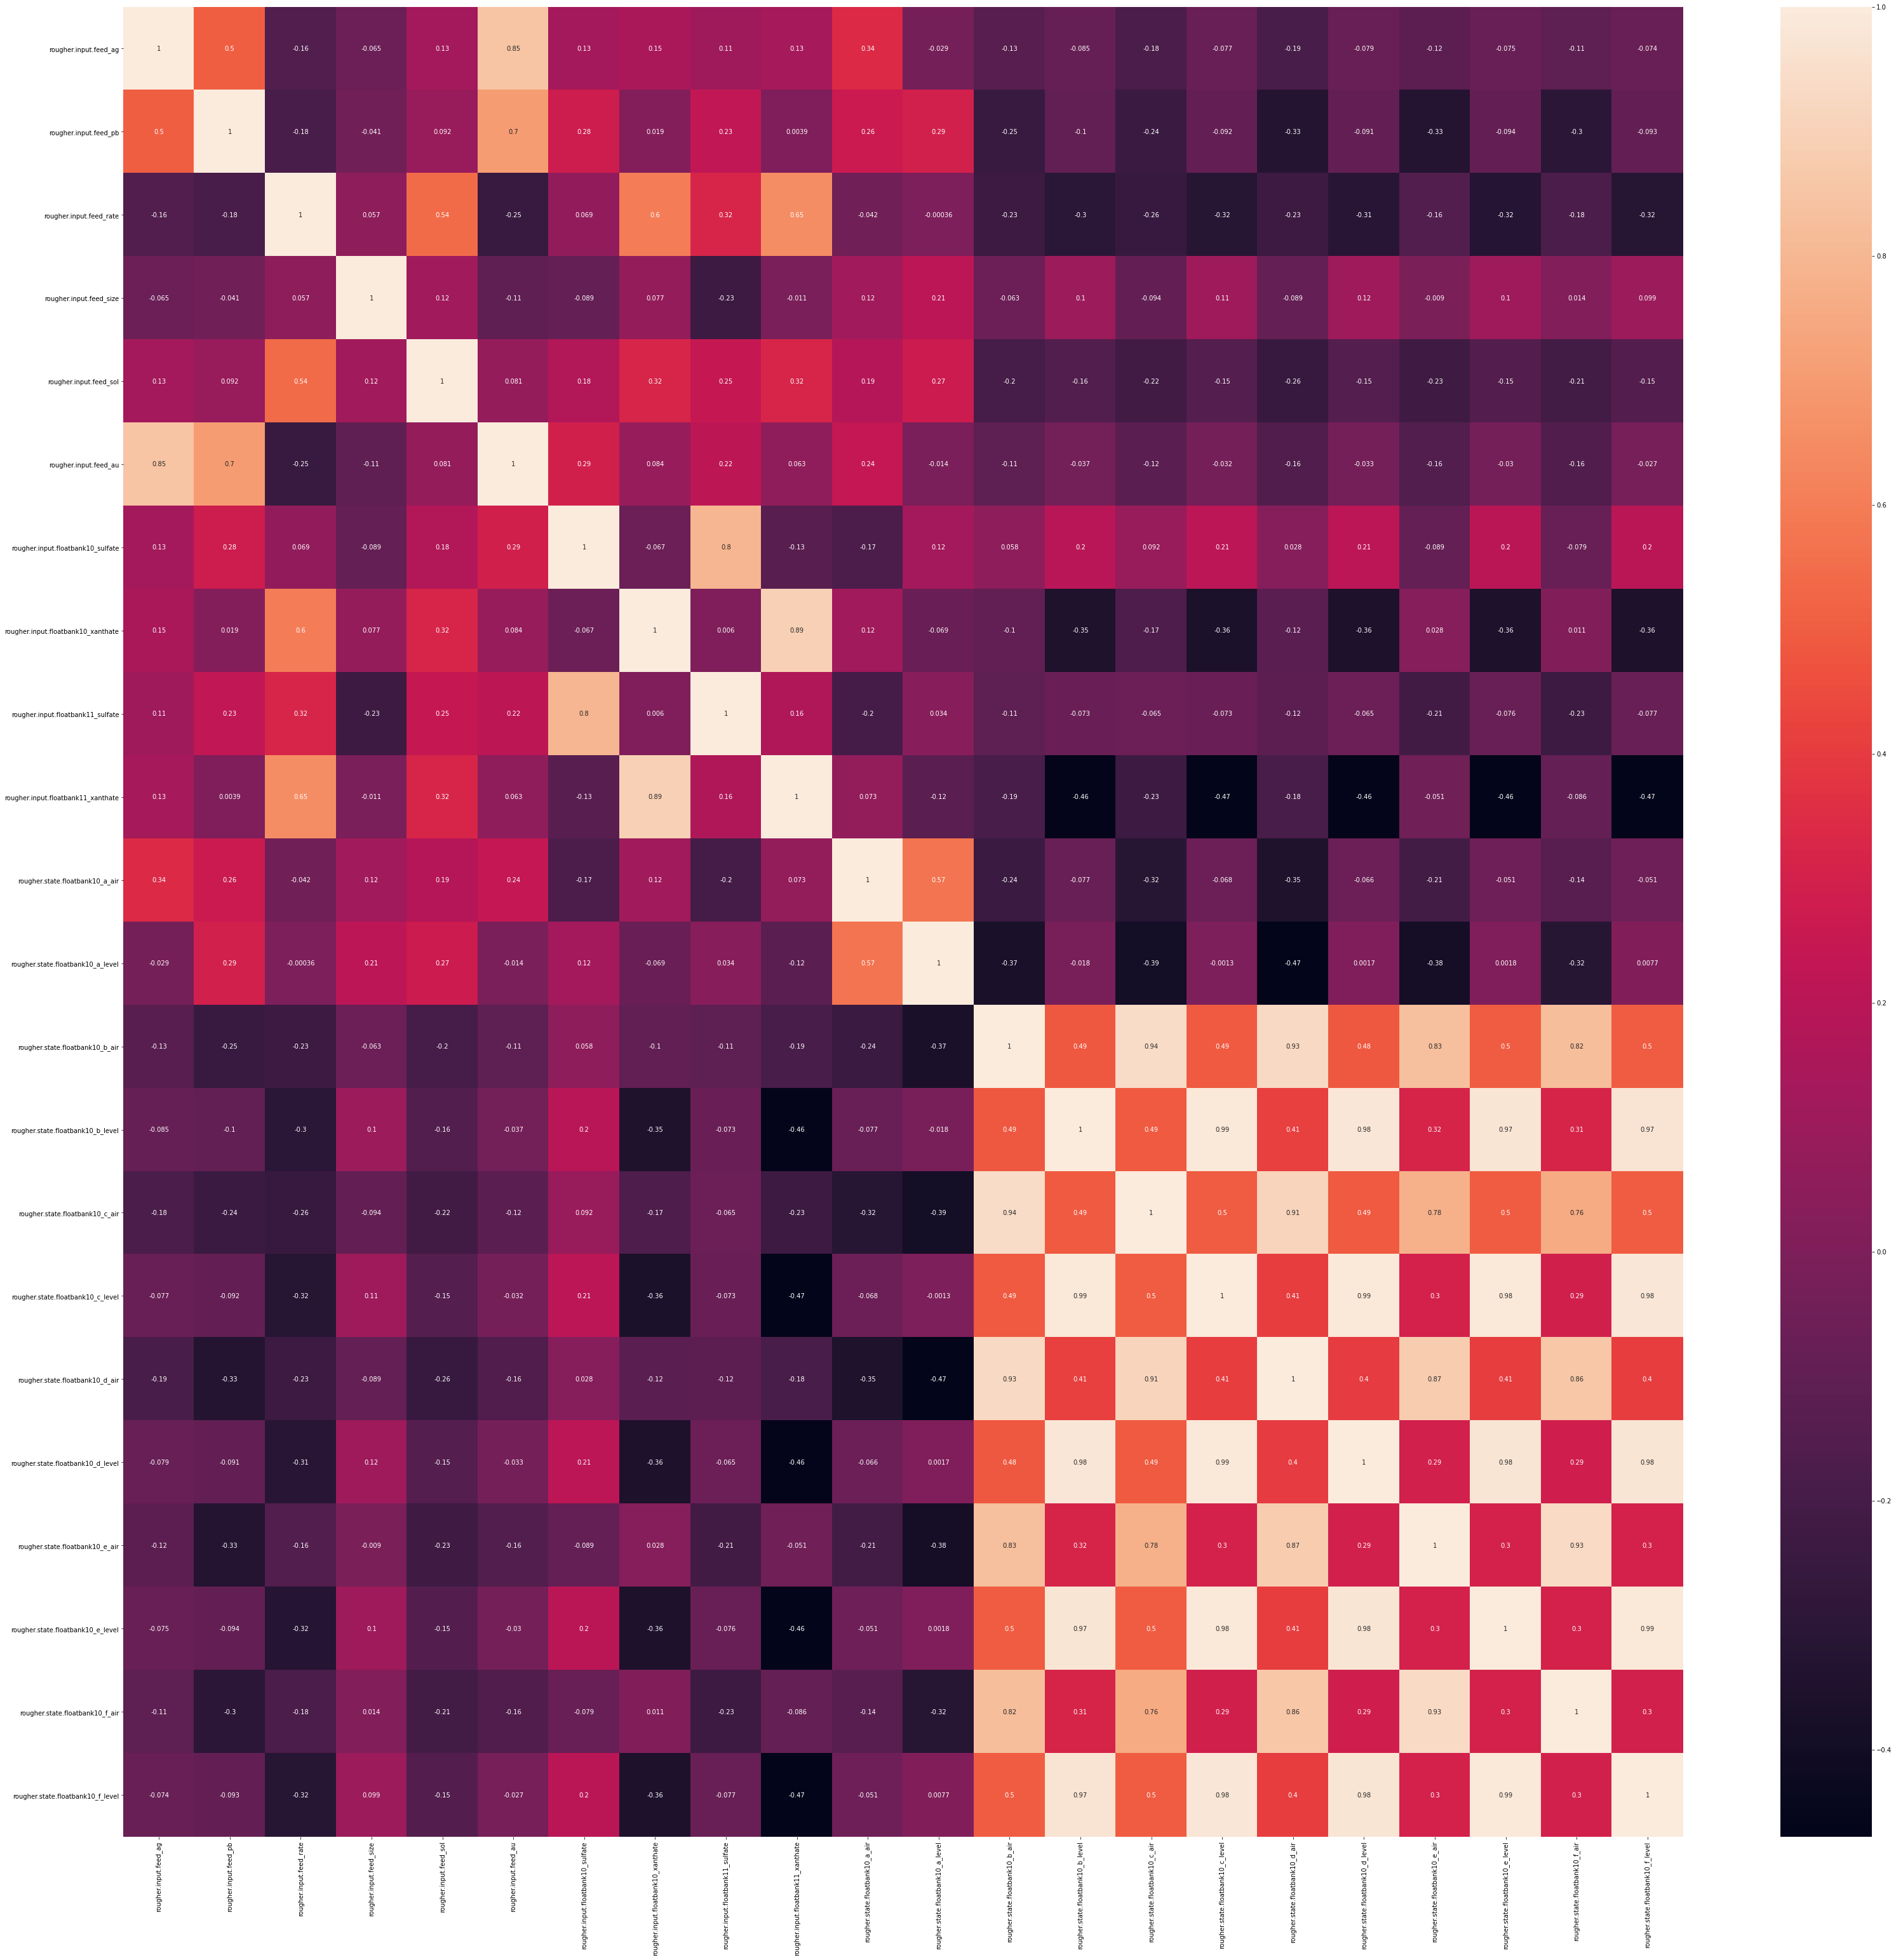

In [47]:
plt.figure(figsize=(55, 53))
sns.heatmap(features_floatation_train.corr(), annot=True);

Как видно из анализа, существует достаточное количество признаков, коэффициент корреляции которых превышает 0.6. В случае использования в дальнейшем модели линейной регрессии это может отрицательно сказаться на качестве предсказаний модели. Поэтому необходимо подготовить отдельный датасет для модели линейной регрессии путем компенсации мультиколлинеарности. Используем простейший способ - удалим схожие признаки, оставив наиболее значимые.

Для этого напишем функцию нахождения признаков с сильной корреляцией, которые необходимо удалить:

In [48]:
def find_features(df):
    df = df.corr()
    k = pd.DataFrame(index=range(len(df)**2), columns=['feature_1', 'feature_2', 'coef'])   
    n = 0
    for i in df.columns:
        m = df[(abs(df[i])>=0.6) & (abs(df[i])<1)] # фильруем значимые коэффициенты корреляции
        
        for j in range(len(m)):
            k.iloc[n] = [i, m.index[j], m[i][j]]
            n += 1

    # удаляем дубликаты по матрице и затем удаляем пропуски, оставшиеся после заполения датафрейма            
    k = k.drop_duplicates(subset='coef', keep='first', ignore_index=True).dropna()

    # Чтобы удалить один из парных признаков необходимо определить какой из них более важный.
    # Поскольку по условию мы не знаем степень значимости признаков, будем удалять признаки из 
    # крайнего левого столбца feature_1. Для этого используем метод drop_duplicates(), чтобы удалить дубликаты. 
    k = k['feature_1'].drop_duplicates().reset_index(drop=True)
    
    return k

Признаки с сильной корреляцией в трейне для этапа флотации : 

In [49]:
find_features(features_floatation_train)

0                  rougher.input.feed_ag
1                  rougher.input.feed_pb
2                rougher.input.feed_rate
3      rougher.input.floatbank10_sulfate
4     rougher.input.floatbank10_xanthate
5        rougher.state.floatbank10_b_air
6      rougher.state.floatbank10_b_level
7        rougher.state.floatbank10_c_air
8      rougher.state.floatbank10_c_level
9        rougher.state.floatbank10_d_air
10     rougher.state.floatbank10_d_level
11       rougher.state.floatbank10_e_air
12     rougher.state.floatbank10_e_level
Name: feature_1, dtype: object

Признаки с сильной корреляцией в тесте для этапа флотации : 

In [50]:
find_features(features_floatation_test)

0                  rougher.input.feed_ag
1                  rougher.input.feed_pb
2                rougher.input.feed_rate
3      rougher.input.floatbank10_sulfate
4     rougher.input.floatbank10_xanthate
5        rougher.state.floatbank10_b_air
6      rougher.state.floatbank10_b_level
7        rougher.state.floatbank10_c_air
8      rougher.state.floatbank10_c_level
9        rougher.state.floatbank10_d_air
10     rougher.state.floatbank10_d_level
11       rougher.state.floatbank10_e_air
12     rougher.state.floatbank10_e_level
13       rougher.state.floatbank10_f_air
Name: feature_1, dtype: object

Для тестовой выборки оказалось наибольшее количество сильно коррелирующих признаков - 14. Будем ориентироваться на нее и удалим во всех выборках указанные признаки - получим тренировочную, валидационную и тестовую выборки для исследования модели линейной регрессии на этапе флотации:

In [51]:
features_floatation_train_linear = features_floatation_train.drop(
    find_features(features_floatation_test), axis=1)

features_floatation_test_linear = features_floatation_test.drop(
    find_features(features_floatation_test), axis=1)

Для этапа очистки проверка на мультиколлинеарность:

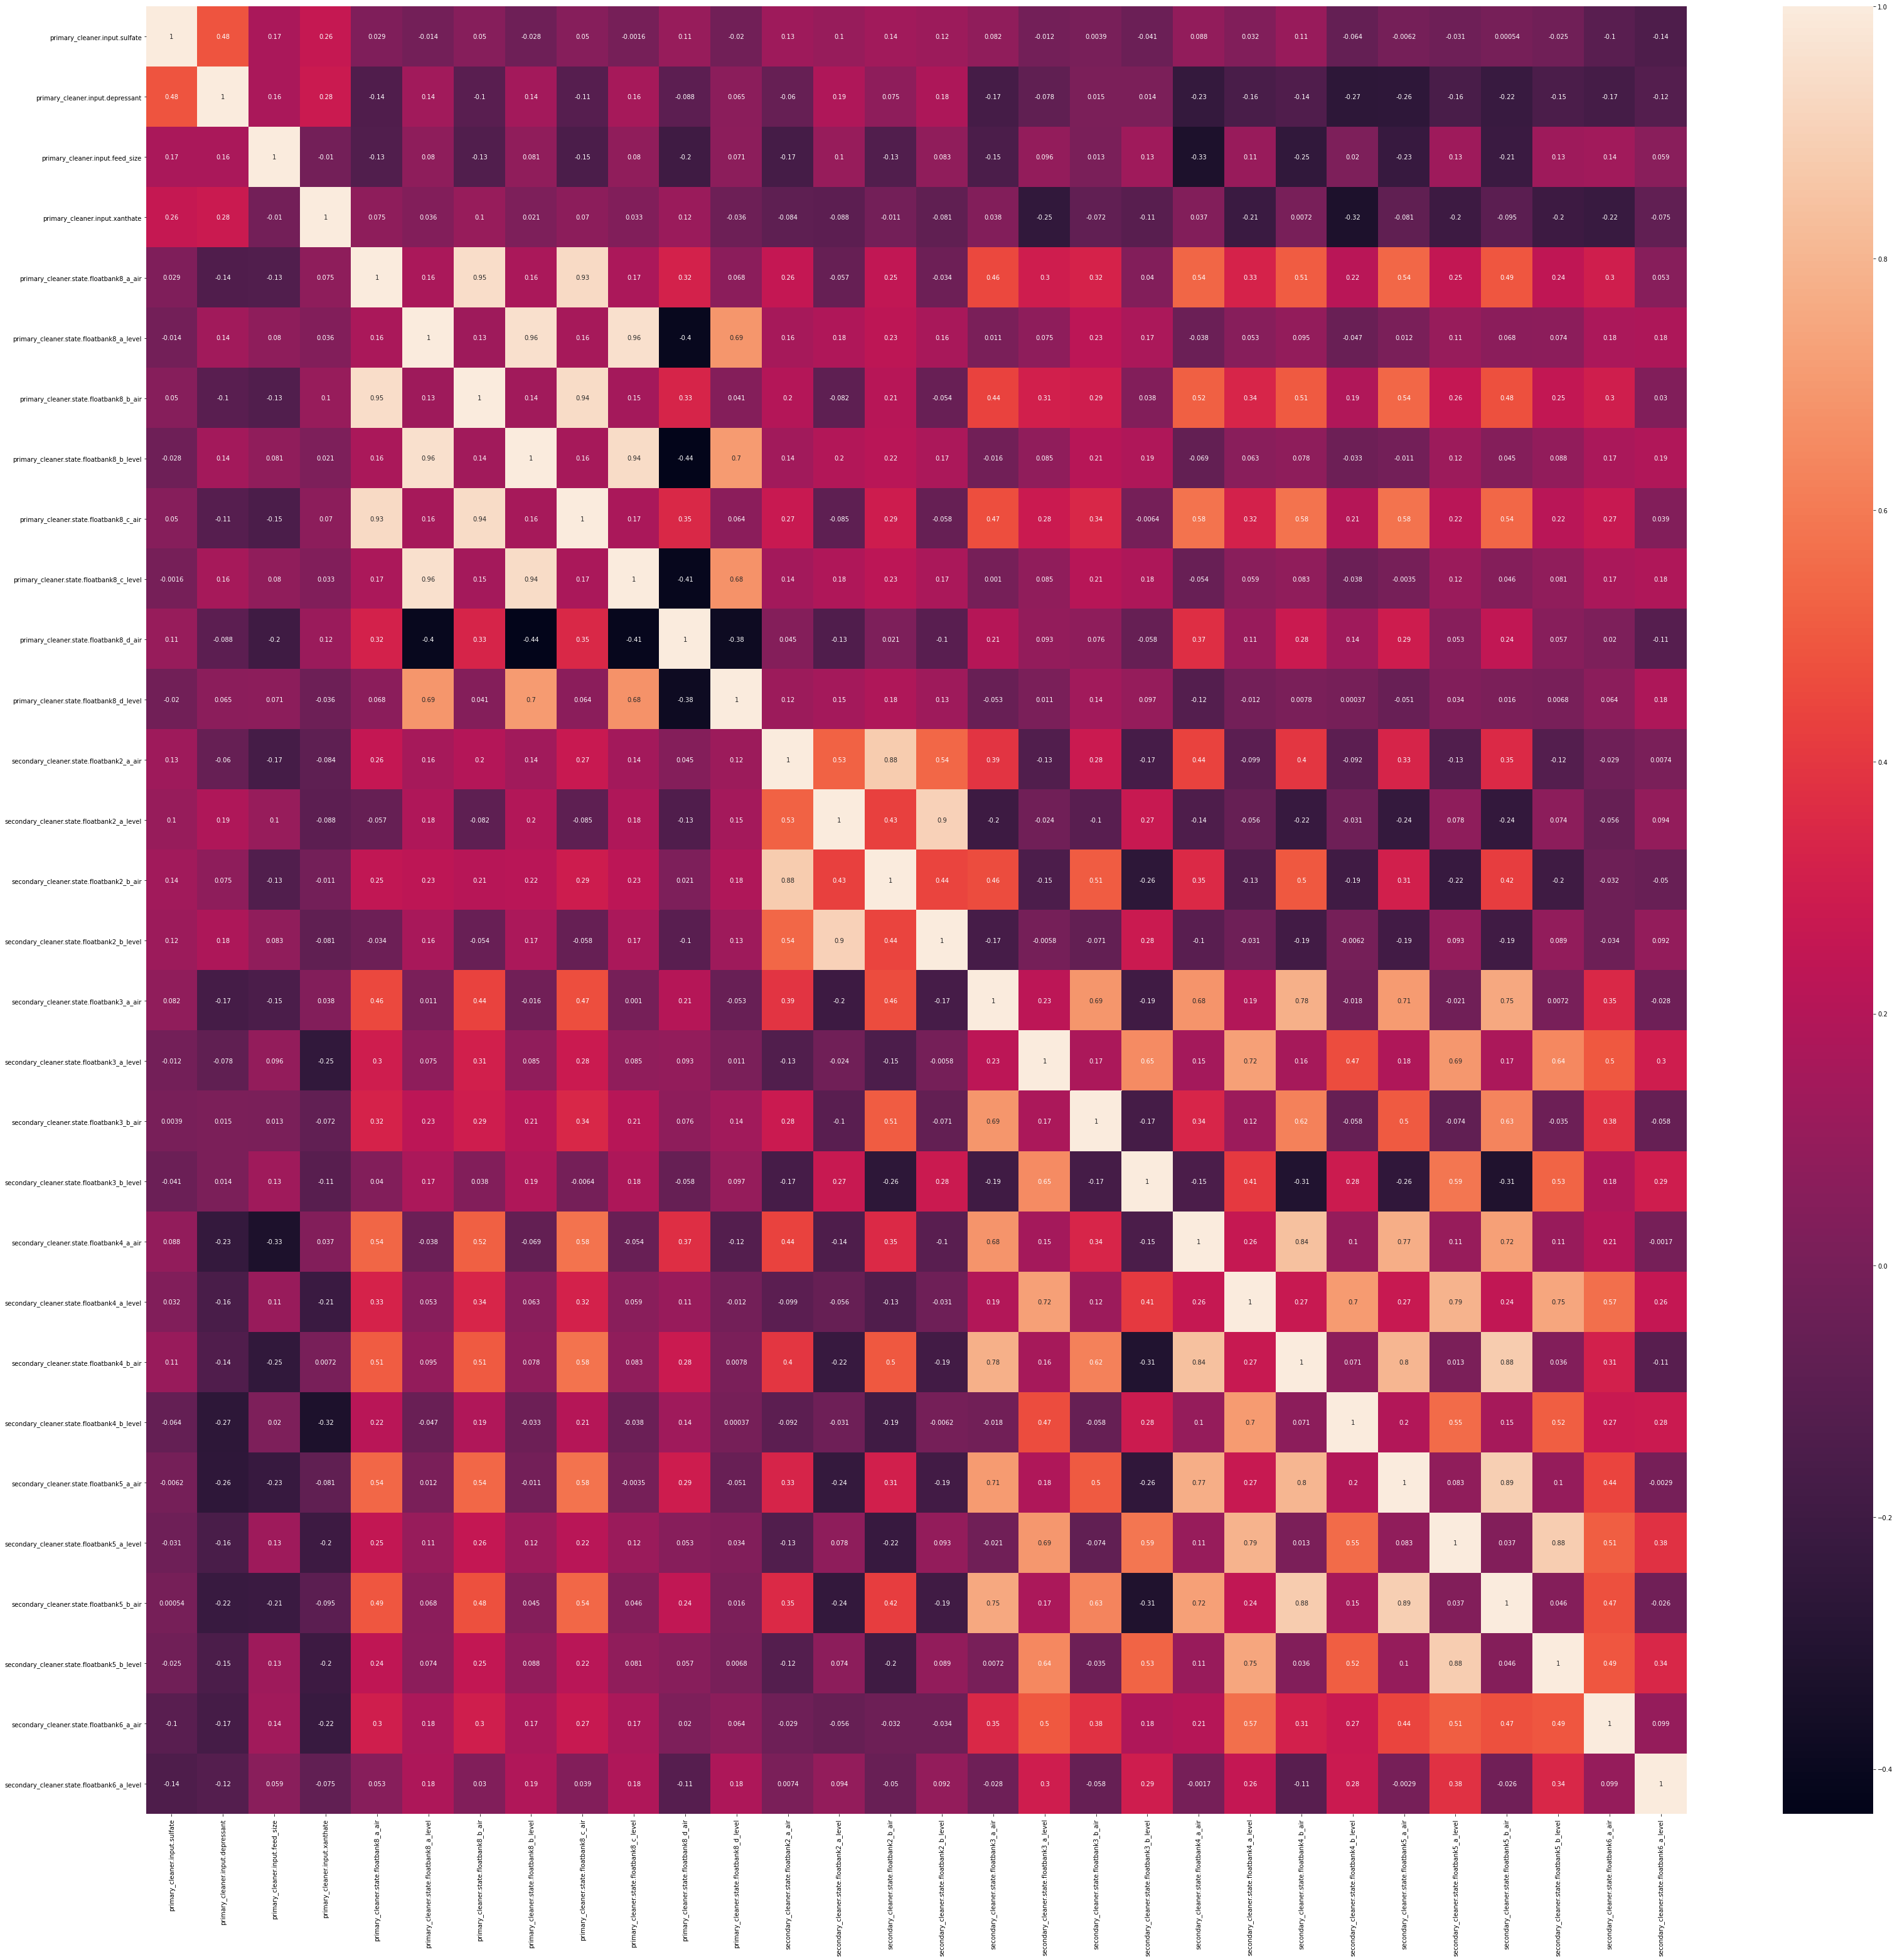

In [52]:
plt.figure(figsize=(55, 53))
sns.heatmap(features_clearance_train.corr(), annot=True);

Выводы аналогичные: удаляем коллинеарные признаки.

Признаки с сильной корреляцией в трейне для этапа очистки: 

In [53]:
find_features(features_clearance_train)

0         primary_cleaner.state.floatbank8_a_air
1       primary_cleaner.state.floatbank8_a_level
2         primary_cleaner.state.floatbank8_b_air
3       primary_cleaner.state.floatbank8_b_level
4       primary_cleaner.state.floatbank8_c_level
5       secondary_cleaner.state.floatbank2_a_air
6     secondary_cleaner.state.floatbank2_a_level
7       secondary_cleaner.state.floatbank3_a_air
8     secondary_cleaner.state.floatbank3_a_level
9       secondary_cleaner.state.floatbank3_b_air
10      secondary_cleaner.state.floatbank4_a_air
11    secondary_cleaner.state.floatbank4_a_level
12      secondary_cleaner.state.floatbank4_b_air
13      secondary_cleaner.state.floatbank5_a_air
14    secondary_cleaner.state.floatbank5_a_level
Name: feature_1, dtype: object

Признаки с сильной корреляцией в тесте для этапа очистки: 

In [54]:
find_features(features_clearance_test)

0         primary_cleaner.state.floatbank8_a_air
1       primary_cleaner.state.floatbank8_a_level
2         primary_cleaner.state.floatbank8_b_air
3         primary_cleaner.state.floatbank8_c_air
4       secondary_cleaner.state.floatbank2_a_air
5     secondary_cleaner.state.floatbank2_a_level
6       secondary_cleaner.state.floatbank2_b_air
7       secondary_cleaner.state.floatbank3_a_air
8     secondary_cleaner.state.floatbank3_a_level
9       secondary_cleaner.state.floatbank3_b_air
10      secondary_cleaner.state.floatbank4_a_air
11      secondary_cleaner.state.floatbank4_b_air
12      secondary_cleaner.state.floatbank5_a_air
Name: feature_1, dtype: object

Для трейновой выборки оказалось наибольшее количество сильно коррелирующих признаков - 15. Будем ориентироваться на нее и удалим во всех выборках указанные признаки - получим тренировочную, валидационную и тестовую выборки для исследования модели линейной регрессии на этапе очистки:

In [55]:
features_clearance_train_linear = features_clearance_train.drop(
    find_features(features_clearance_train), axis=1)

features_clearance_test_linear = features_clearance_test.drop(
    find_features(features_clearance_train), axis=1)

Таким образом, на данном промежуточном шаге выяснили, что данные по условию признаки мультиколлинеарны, в связи с чем для дальнейшего исследования модели линейной регрессии были отредактированы полученные ранее выборки для этапов флотации и очистки путем удаления сильно коррелирующих признаков.

#### Масштабирование

Проверим ско признаков в выборках:

In [56]:
features_floatation_train.describe()

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
count,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000
mean,8.579195,3.505465,473.938265,60.239856,36.290933,7.866577,11.746225,5.853080,11.368269,5.803930,1124.717520,-369.470105,1320.724794,-464.261562,1299.381782,-465.057320,1210.335236,-465.457377,1084.329957,-464.919119,1035.490299,-464.688631
std,1.896284,1.090064,104.137249,23.005310,4.977652,1.919506,3.307977,1.106509,3.798083,1.239005,169.308048,93.955779,183.164531,57.400744,213.411457,55.903513,210.431555,55.771393,186.264888,56.602962,175.052279,56.645965
min,0.010000,0.010000,0.012786,9.659576,0.010000,0.010000,0.001083,0.001428,0.000098,0.000290,-0.041078,-650.202881,-0.653384,-650.260008,-0.035112,-640.995627,-0.554299,-640.519003,-1.970275,-649.443911,-2.430587,-649.880981
25%,7.132802,2.766515,420.723210,48.966751,34.086892,6.596217,9.842944,5.113485,9.502098,5.096661,999.799195,-499.787788,1199.367169,-500.183146,1103.096392,-500.211811,1059.708509,-500.359197,951.248809,-500.250033,900.966986,-500.476526
50%,8.156092,3.414267,499.449303,55.269784,37.008684,7.649138,11.661747,5.949895,11.382460,5.992219,1001.682290,-300.175169,1301.367954,-499.764806,1300.214100,-499.682570,1200.744308,-499.465285,1050.158925,-499.611447,1000.053757,-499.364335
75%,9.918304,4.220115,547.326781,66.007526,39.410720,9.066976,13.584044,6.602486,13.498047,6.642274,1299.505214,-299.963169,1449.559140,-400.425547,1450.353307,-400.664948,1344.378462,-401.052891,1199.903428,-400.596104,1100.165435,-401.014951
max,14.596026,7.142594,717.508837,484.967466,48.363177,13.126043,36.118275,9.703448,37.980648,9.698407,1521.980372,-281.039299,1809.194008,-296.383080,2499.129174,-292.155509,1817.199290,-208.330673,1922.636637,-272.199598,1706.307502,-191.718480


In [57]:
features_clearance_train.describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_a_air,primary_cleaner.state.floatbank8_a_level,primary_cleaner.state.floatbank8_b_air,primary_cleaner.state.floatbank8_b_level,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_c_level,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,secondary_cleaner.state.floatbank2_a_air,secondary_cleaner.state.floatbank2_a_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_a_air,secondary_cleaner.state.floatbank3_a_level,secondary_cleaner.state.floatbank3_b_air,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_a_air,secondary_cleaner.state.floatbank4_a_level,secondary_cleaner.state.floatbank4_b_air,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_a_air,secondary_cleaner.state.floatbank5_a_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000
mean,133.213938,8.855281,7.322310,0.881455,1608.010260,-488.776276,1608.624449,-489.172523,1608.881920,-489.606288,1542.262260,-483.463589,29.685606,-502.223723,24.900592,-503.695352,29.242738,-478.245518,22.656283,-488.924813,19.979788,-478.702912,15.486812,-460.237231,16.774657,-483.957839,13.064236,-483.967726,19.576675,-506.805007
std,39.604988,3.375435,0.614062,0.375683,128.381451,35.703034,131.101079,33.603376,134.260578,35.622851,278.383053,47.099473,5.812810,60.279579,6.016986,62.835150,5.636710,54.653487,4.995841,41.926730,5.663611,50.739376,5.255555,58.848850,5.831978,37.892065,5.765567,39.206771,5.764496,37.086065
min,0.003112,0.000000,1.080000,0.000005,0.006352,-798.641662,0.008700,-740.122129,0.015159,-799.803073,0.008655,-799.788598,0.077503,-799.606441,0.000000,-799.873878,0.000000,-799.613013,0.000000,-759.177381,0.000000,-799.709069,0.000000,-799.889113,-0.372054,-797.142475,0.646208,-800.006180,0.195324,-809.398668
25%,106.859801,6.038358,6.960000,0.604805,1595.695815,-500.287950,1558.959943,-500.375607,1549.873901,-500.601650,1452.697692,-500.459897,25.107090,-500.248792,22.043888,-500.270983,24.991662,-500.175043,19.948440,-500.110576,14.990463,-500.628716,11.894590,-500.149141,11.083699,-500.363203,8.994384,-500.105994,14.989244,-500.745309
50%,132.999290,8.034222,7.290000,0.887473,1601.827195,-499.909251,1601.820517,-499.937866,1601.574628,-499.871677,1600.168762,-499.831842,30.034084,-499.959205,27.022134,-500.014051,28.016464,-499.877836,22.037443,-499.966795,20.001601,-499.681587,14.975474,-499.388853,17.931987,-499.702479,11.997537,-499.914556,19.984165,-500.061488
75%,159.825396,11.516919,7.700000,1.100079,1699.716408,-499.378655,1700.214206,-499.389771,1700.465056,-498.801786,1699.359397,-498.480878,34.902699,-499.593172,28.939448,-499.763998,34.990058,-437.069363,25.970312,-499.757527,24.990768,-477.486391,20.059286,-400.039047,21.346135,-487.864322,17.982826,-453.274822,24.991615,-499.536481
max,250.127834,20.052255,10.470000,2.512968,2079.531340,-330.134203,2114.906758,-347.354380,2013.156457,-346.653450,2398.903635,-30.601828,52.651399,-127.875565,35.152122,-212.064665,44.260464,-191.678810,35.072841,-159.742331,30.115735,-245.239184,24.007913,-145.071088,43.709931,-275.073125,27.926001,-157.396071,32.188906,-104.427459


In [58]:
features_floatation_train_linear.describe()

,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_f_level
count,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000
mean,60.239856,36.290933,7.866577,11.368269,5.803930,1124.717520,-369.470105,-464.688631
std,23.005310,4.977652,1.919506,3.798083,1.239005,169.308048,93.955779,56.645965
min,9.659576,0.010000,0.010000,0.000098,0.000290,-0.041078,-650.202881,-649.880981
25%,48.966751,34.086892,6.596217,9.502098,5.096661,999.799195,-499.787788,-500.476526
50%,55.269784,37.008684,7.649138,11.382460,5.992219,1001.682290,-300.175169,-499.364335
75%,66.007526,39.410720,9.066976,13.498047,6.642274,1299.505214,-299.963169,-401.014951
max,484.967466,48.363177,13.126043,37.980648,9.698407,1521.980372,-281.039299,-191.718480


In [59]:
features_clearance_train_linear.describe()

,primary_cleaner.input.sulfate,primary_cleaner.input.depressant,primary_cleaner.input.feed_size,primary_cleaner.input.xanthate,primary_cleaner.state.floatbank8_c_air,primary_cleaner.state.floatbank8_d_air,primary_cleaner.state.floatbank8_d_level,secondary_cleaner.state.floatbank2_b_air,secondary_cleaner.state.floatbank2_b_level,secondary_cleaner.state.floatbank3_b_level,secondary_cleaner.state.floatbank4_b_level,secondary_cleaner.state.floatbank5_b_air,secondary_cleaner.state.floatbank5_b_level,secondary_cleaner.state.floatbank6_a_air,secondary_cleaner.state.floatbank6_a_level
count,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000,14149.000000
mean,133.213938,8.855281,7.322310,0.881455,1608.881920,1542.262260,-483.463589,24.900592,-503.695352,-488.924813,-460.237231,13.064236,-483.967726,19.576675,-506.805007
std,39.604988,3.375435,0.614062,0.375683,134.260578,278.383053,47.099473,6.016986,62.835150,41.926730,58.848850,5.765567,39.206771,5.764496,37.086065
min,0.003112,0.000000,1.080000,0.000005,0.015159,0.008655,-799.788598,0.000000,-799.873878,-759.177381,-799.889113,0.646208,-800.006180,0.195324,-809.398668
25%,106.859801,6.038358,6.960000,0.604805,1549.873901,1452.697692,-500.459897,22.043888,-500.270983,-500.110576,-500.149141,8.994384,-500.105994,14.989244,-500.745309
50%,132.999290,8.034222,7.290000,0.887473,1601.574628,1600.168762,-499.831842,27.022134,-500.014051,-499.966795,-499.388853,11.997537,-499.914556,19.984165,-500.061488
75%,159.825396,11.516919,7.700000,1.100079,1700.465056,1699.359397,-498.480878,28.939448,-499.763998,-499.757527,-400.039047,17.982826,-453.274822,24.991615,-499.536481
max,250.127834,20.052255,10.470000,2.512968,2013.156457,2398.903635,-30.601828,35.152122,-212.064665,-159.742331,-145.071088,27.926001,-157.396071,32.188906,-104.427459


Значения сильно рознятся - масштабируем их.

Создадим объекты структуры StandardScaler() и настроим их на обучающих данных:

In [60]:
scaler_floatation = StandardScaler()
scaler_floatation.fit(features_floatation_train)

scaler_clearance = StandardScaler()
scaler_clearance.fit(features_clearance_train)

scaler_floatation_linear = StandardScaler()
scaler_floatation_linear.fit(features_floatation_train_linear)

scaler_clearance_linear = StandardScaler()
scaler_clearance_linear.fit(features_clearance_train_linear)

StandardScaler()

Преобразуем столбцы функцией transform() и преобразуем массивы numpy в датафреймы с сохранением названий признаков:

In [61]:
# масштабирование признаков этапа флотации
features_floatation_train = pd.DataFrame(
    scaler_floatation.transform(features_floatation_train), columns=features_floatation_train.columns)

# features_floatation_valid = pd.DataFrame(
#     scaler_floatation.transform(features_floatation_valid), columns=features_floatation_valid.columns)

features_floatation_test = pd.DataFrame(
    scaler_floatation.transform(features_floatation_test), columns=features_floatation_test.columns)

In [62]:
# масштабирование признаков этапа очистки
features_clearance_train = pd.DataFrame(
    scaler_clearance.transform(features_clearance_train), columns=features_clearance_train.columns)

features_clearance_test = pd.DataFrame(
    scaler_clearance.transform(features_clearance_test), columns=features_clearance_test.columns)

И для модели линейной регрессии:

In [63]:
# масштабирование признаков этапа флотации
features_floatation_train_linear = pd.DataFrame(scaler_floatation_linear.transform(
    features_floatation_train_linear), columns=features_floatation_train_linear.columns)

features_floatation_test_linear = pd.DataFrame(scaler_floatation_linear.transform(
    features_floatation_test_linear), columns=features_floatation_test_linear.columns)

In [64]:
# масштабирование признаков этапа очистки
features_clearance_train_linear = pd.DataFrame(scaler_clearance_linear.transform(
    features_clearance_train_linear), columns=features_clearance_train_linear.columns)

features_clearance_test_linear = pd.DataFrame(scaler_clearance_linear.transform(
    features_clearance_test_linear), columns=features_clearance_test_linear.columns)

In [65]:
features_floatation_train_linear

,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_f_level
0,-0.206623,0.104001,-0.719183,0.123349,0.162949,-0.738388,-0.368238,0.225072
1,-0.128722,-0.107996,-0.723125,0.165324,0.168418,-0.734965,-0.325644,0.257214
2,-0.118638,-0.064150,-0.783747,0.145351,0.323418,-0.738313,-0.325738,0.250009
3,-0.106376,0.114779,-0.910885,0.085357,0.316916,-0.737751,-0.327081,0.263008
4,-0.182254,-0.390412,-1.147664,-0.107360,0.315560,-0.738555,-0.322319,0.252128
...,...,...,...,...,...,...,...,...
14144,1.107542,0.216745,-1.318466,-0.948282,2.705603,0.440210,0.730418,-0.578350
14145,2.575991,0.462206,-1.577523,-1.125018,2.820098,0.424400,0.744609,-0.567289
14146,2.696118,0.760042,-1.740882,-1.259664,2.821882,0.473409,0.747553,-0.745169
14147,2.760442,0.687693,-1.825428,-1.358299,2.819510,0.455911,0.740404,-0.607901


In [66]:
features_floatation_train

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
0,-1.307243,-1.119747,0.476389,-0.206623,0.104001,-0.719183,0.072673,0.140004,0.123349,0.162949,-0.738388,-0.368238,1.541218,0.514760,1.419811,0.408805,1.846756,0.253961,1.718807,0.167067,2.175797,0.225072
1,-1.275213,-1.137067,0.493139,-0.128722,-0.107996,-0.723125,0.068010,0.137994,0.165324,0.168418,-0.734965,-0.325644,1.528897,0.249276,1.410929,0.272384,1.854314,0.277997,1.690647,0.248216,2.080762,0.257214
2,-1.298765,-1.234690,0.538619,-0.118638,-0.064150,-0.783747,0.052716,0.311167,0.145351,0.323418,-0.738313,-0.325738,1.521159,0.248316,1.407149,0.270168,1.851091,0.277987,1.690400,0.264687,2.084173,0.250009
3,-1.337339,-1.346444,0.659270,-0.106376,0.114779,-0.910885,-0.035108,0.316409,0.085357,0.316916,-0.737751,-0.327081,1.525102,0.237664,1.408742,0.270955,1.840996,0.274832,1.699861,0.263052,2.083705,0.263008
4,-1.328054,-1.576651,0.639502,-0.182254,-0.390412,-1.147664,-0.238363,0.312477,-0.107360,0.315560,-0.738555,-0.322319,1.525917,0.255440,1.410358,0.268740,1.850661,0.278783,1.703177,0.283422,2.088992,0.252128
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14144,-1.311738,1.020246,0.834993,1.107542,0.216745,-1.318466,-1.204239,2.987456,-0.948282,2.705603,0.440210,0.730418,-0.933166,-0.601549,-1.178133,-0.596688,-1.253156,-0.604186,-1.259890,-0.605914,-1.061047,-0.578350
14145,-1.296198,0.586706,0.817158,2.575991,0.462206,-1.577523,-1.327002,3.119717,-1.125018,2.820098,0.424400,0.744609,-0.944810,-0.633233,-1.175311,-0.641762,-1.238269,-0.619798,-1.266063,-0.624906,-1.059590,-0.567289
14146,-1.375728,0.472042,0.784998,2.696118,0.760042,-1.740882,-1.559983,3.114886,-1.259664,2.821882,0.473409,0.747553,-0.932429,-0.652564,-1.170444,-0.634897,-1.224349,-0.661562,-1.263374,-0.628727,-1.057063,-0.745169
14147,-1.334797,0.364278,0.679833,2.760442,0.687693,-1.825428,-1.673621,3.113172,-1.358299,2.819510,0.455911,0.740404,-0.909799,-0.623272,-1.149801,-0.629321,-1.265047,-0.563204,-1.249556,-0.602840,-1.051978,-0.607901


ско признакового пространства:

In [67]:
features_floatation_train_linear.describe()

,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_f_level
count,1.414900e+04,1.414900e+04,1.414900e+04,1.414900e+04,1.414900e+04,1.414900e+04,1.414900e+04,1.414900e+04
mean,2.089093e-16,-4.499585e-16,-1.767694e-16,1.285596e-16,-3.374689e-16,8.999170e-16,-4.499585e-16,3.535388e-16
std,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00
min,-2.198713e+00,-7.289022e+00,-4.093165e+00,-2.993239e+00,-4.684278e+00,-6.643502e+00,-2.988030e+00,-3.269410e+00
25%,-4.900392e-01,-4.428030e-01,-6.618392e-01,-4.913630e-01,-5.708569e-01,-7.378429e-01,-1.387060e+00,-6.318042e-01
50%,-2.160479e-01,1.441999e-01,-1.132826e-01,3.736356e-03,1.519728e-01,-7.267202e-01,7.375532e-01,-6.121694e-01
75%,2.507192e-01,6.267810e-01,6.253906e-01,5.607704e-01,6.766502e-01,1.032401e+00,7.398097e-01,1.124104e+00
max,1.846281e+01,2.425375e+00,2.740107e+00,7.007039e+00,3.143340e+00,2.346474e+00,9.412293e-01,4.819051e+00


In [68]:
features_floatation_train.describe()

,rougher.input.feed_ag,rougher.input.feed_pb,rougher.input.feed_rate,rougher.input.feed_size,rougher.input.feed_sol,rougher.input.feed_au,rougher.input.floatbank10_sulfate,rougher.input.floatbank10_xanthate,rougher.input.floatbank11_sulfate,rougher.input.floatbank11_xanthate,rougher.state.floatbank10_a_air,rougher.state.floatbank10_a_level,rougher.state.floatbank10_b_air,rougher.state.floatbank10_b_level,rougher.state.floatbank10_c_air,rougher.state.floatbank10_c_level,rougher.state.floatbank10_d_air,rougher.state.floatbank10_d_level,rougher.state.floatbank10_e_air,rougher.state.floatbank10_e_level,rougher.state.floatbank10_f_air,rougher.state.floatbank10_f_level
count,1.414900e+04,1.414900e+04,1.414900e+04,1.414900e+04,1.414900e+04,1.414900e+04,1.414900e+04,14149.000000,1.414900e+04,1.414900e+04,1.414900e+04,1.414900e+04,1.414900e+04,1.414900e+04,1.414900e+04,1.414900e+04,1.414900e+04,1.414900e+04,1.414900e+04,1.414900e+04,1.414900e+04,1.414900e+04
mean,-8.838471e-17,7.231476e-17,-2.571191e-16,2.089093e-16,-4.499585e-16,-1.767694e-16,-1.606995e-16,0.000000,1.285596e-16,-3.374689e-16,8.999170e-16,-4.499585e-16,5.142383e-16,1.606995e-16,-7.713574e-16,-1.157036e-15,-7.713574e-16,-7.713574e-16,9.641968e-17,6.106580e-16,5.463782e-16,3.535388e-16
std,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00,1.000035e+00
min,-4.519099e+00,-3.206774e+00,-4.551131e+00,-2.198713e+00,-7.289022e+00,-4.093165e+00,-3.550676e+00,-5.288580,-2.993239e+00,-4.684278e+00,-6.643502e+00,-2.988030e+00,-7.214415e+00,-3.240464e+00,-6.089002e+00,-3.147289e+00,-5.754519e+00,-3.139025e+00,-5.832224e+00,-3.260100e+00,-5.929415e+00,-3.269410e+00
25%,-7.627780e-01,-6.779198e-01,-5.110269e-01,-4.900392e-01,-4.428030e-01,-6.618392e-01,-5.753813e-01,-0.668428,-4.913630e-01,-5.708569e-01,-7.378429e-01,-1.387060e+00,-6.625841e-01,-6.258256e-01,-9.197835e-01,-6.288645e-01,-7.158244e-01,-6.258236e-01,-7.144978e-01,-6.242105e-01,-7.685022e-01,-6.318042e-01
50%,-2.231303e-01,-8.366522e-02,2.449838e-01,-2.160479e-01,1.441999e-01,-1.132826e-01,-2.553880e-02,0.087498,3.736356e-03,1.519728e-01,-7.267202e-01,7.375532e-01,-1.056838e-01,-6.185373e-01,3.900198e-03,-6.193971e-01,-4.557903e-02,-6.097949e-01,-1.834604e-01,-6.129282e-01,-2.024412e-01,-6.121694e-01
75%,7.062003e-01,6.556269e-01,7.047537e-01,2.507192e-01,6.267810e-01,6.253906e-01,5.555912e-01,0.677295,5.607704e-01,6.766502e-01,1.032401e+00,7.398097e-01,7.034053e-01,1.112151e+00,7.074450e-01,1.151889e+00,6.370146e-01,1.154835e+00,6.205010e-01,1.136430e+00,3.694749e-01,1.124104e+00
max,3.173070e+00,3.336738e+00,2.339021e+00,1.846281e+01,2.425375e+00,2.740107e+00,7.367919e+00,3.479868,7.007039e+00,3.143340e+00,2.346474e+00,9.412293e-01,2.666927e+00,2.924778e+00,5.621956e+00,3.092971e+00,2.884004e+00,4.610532e+00,4.500775e+00,3.404881e+00,3.832232e+00,4.819051e+00


ско выровнялось.

### Промежуточные выводы

**На 1 шаге проведена подготовка данных:**

1. Загружены и изучены исходные данные - три датасета:
- data_full - общий датасет: 19439 объектов с 87 признаками,
- data_train - тренировочная выборка: 14149 объектов с 87 признаками,
- data_test - тестовая выборка: 5290 объектов с 53 признаками.
Во всех датасетах первый признак date имеет тип данных object, остальные - тип данных float64.
Дубликаты не обнаружены.
Имеется 4481 пропуск, но в целевых признаках пропусков нет.

2. Проверена правильность расчета эффективности обогащения: признак в датасетах рассчитан верно.

3. Проведен анализ признаков, недоступных в тестовой выборке.
Отсутствующие признаки относятся к двум типам параметров: 
- выходные признаки или параметры продукта (к ним же относятся и целевые признаки); их количество - 30; данные признаки не могут быть рассчитаны в ходе рабочего процесса, они являются выходом, который должны прогнозировать модели;
- расчетные характеристики; х количество - 4; из расчетных признаков можем выделить *зависимые от выхода* (rougher.calculation.sulfate_to_au_concentrate - зависит от rougher.output.concentrate_au) и *независимые от выхода* признаки(rougher.calculation.floatbank10_sulfate_to_au_feed, rougher.calculation.floatbank11_sulfate_to_au_feed, rougher.calculation.au_pb_ratio). 
Однако, это предположение основывается на названии признаков, поскольку выражений для их расчета нам не дано по условию. Поэтому не будем рисковать и не будем использовать эти признаки в ходе исследования. Таким образом, при формировании нецелевых признаков в ходе этапов флотации и очистки мы должны избавляться от соответствующих 34 зависимых признаков.

4. Проведена преобработка данных:
- найдены аномалии за пределами полуторных межквартильных интервалов, но поскольку информации о нюансах техпроцесса нет, принято решение их не удалять;
- все пропуски в общем датасете заполнены предыдущими числовыми значениями;
- сформированы новые тренировочная и тестовая выборки с общим набором признаков;
- удален ненформативный столбец date;
- выделены целевые и нецелевые признаки тренировочной и тестовой выборок для этапов флотации и очистки;
- обнаружена мультиколлинеарность нецелевых признаков для обоих этапов, в связи с чем подготовлены отдельные выборки с удаленными коррелирующими признаками;
- проведно масштабирование нецелевых признаков для всех подготовленных выборок.

## Анализ данных

### Анализ изменения концентрации металлов (Au, Ag, Pb) на различных этапах очистки

Определим соответствующие признаки на каждом из этапов.<br>

**До флотации:**<br>
концентрация золота - rougher.input.feed_au<br>
концентрация серебра - rougher.input.feed_ag<br>
концентрация свинца - rougher.input.feed_pb<br>

**После флотации на первой стадии очистки:**<br>
концентрация золота - rougher.output.concentrate_au<br>
концентрация серебра - rougher.output.concentrate_ag<br>
концентрация свинца - rougher.output.concentrate_pb<br>

**После первой стадии очистки:**<br>
концентрация золота - primary_cleaner.output.concentrate_au<br>
концентрация серебра - primary_cleaner.output.concentrate_ag<br>
концентрация свинца - primary_cleaner.output.concentrate_pb<br>

**После финальной (второй) стадии очистки:**<br>
концентрация золота - final.output.concentrate_au<br>
концентрация серебра - final.output.concentrate_ag<br>
концентрация свинца - final.output.concentrate_pb<br>

**Концентрация золота**

In [69]:
data_full['rougher.input.feed_au'].median()

8.125838836648287

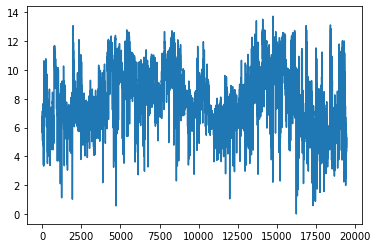

In [70]:
data_full['rougher.input.feed_au'].plot(kind='line');

In [71]:
data_full['rougher.output.concentrate_au'].median()

20.280214025891475

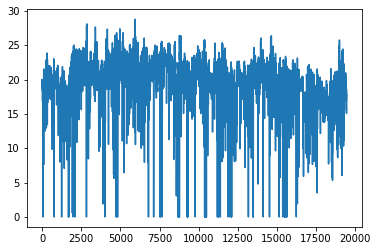

In [72]:
data_full['rougher.output.concentrate_au'].plot(kind='line');

In [73]:
data_full['primary_cleaner.output.concentrate_au'].median()

32.841295480233306

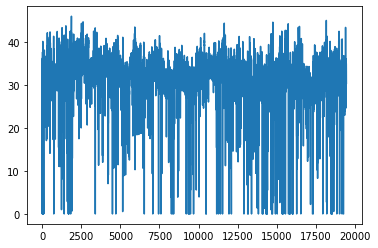

In [74]:
data_full['primary_cleaner.output.concentrate_au'].plot(kind='line');

In [75]:
data_full['final.output.concentrate_au'].median()

45.01124391455689

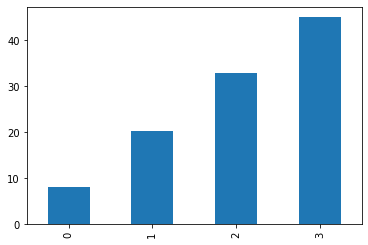

In [76]:
pd.Series([data_full['rougher.input.feed_au'].median(), \
      data_full['rougher.output.concentrate_au'].median(), \
     data_full['primary_cleaner.output.concentrate_au'].median(), \
     data_full['final.output.concentrate_au'].median()])\
    .plot(kind='bar');

Анализируя графики и медианные значения можно сделать вывод, что медианная концентрация золота в сырьевой смеси логично возрастает от этапа к этапу и после финальной очистки достигает наибольшего значения. В то же время есть периоды спада медианных значений для каждого из этапов, частотность которых нельзя точно установить. Возможно это обусловлено особенностями процессов, происходящих в ходе очистки.  

**Концентрация серебра**

In [77]:
data_full['rougher.input.feed_ag'].median()

8.593574167368724

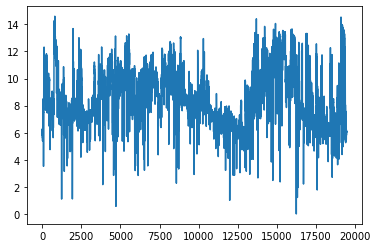

In [78]:
data_full['rougher.input.feed_ag'].plot(kind='line');

In [79]:
data_full['rougher.output.concentrate_ag'].median()

12.098114967346191

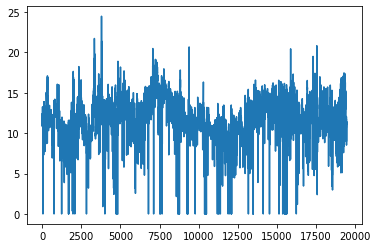

In [80]:
data_full['rougher.output.concentrate_ag'].plot(kind='line');

In [81]:
data_full['primary_cleaner.output.concentrate_ag'].median()

8.507297972365805

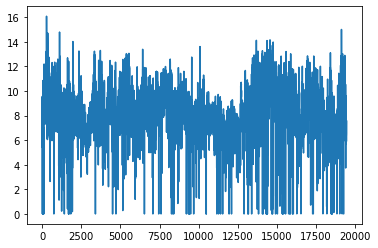

In [82]:
data_full['primary_cleaner.output.concentrate_ag'].plot(kind='line');

In [83]:
data_full['final.output.concentrate_ag'].median()

5.066039118467836

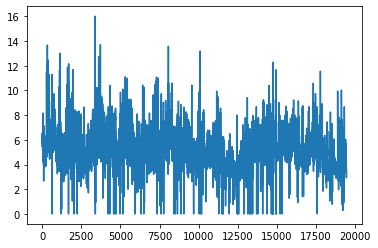

In [84]:
data_full['final.output.concentrate_ag'].plot(kind='line');

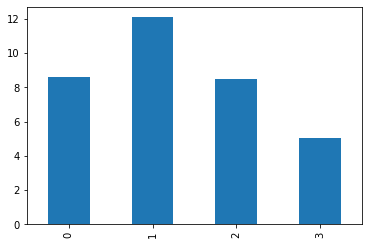

In [85]:
pd.Series([data_full['rougher.input.feed_ag'].median(), \
      data_full['rougher.output.concentrate_ag'].median(), \
     data_full['primary_cleaner.output.concentrate_ag'].median(), \
     data_full['final.output.concentrate_ag'].median()])\
    .plot(kind='bar');

Концентрация серебра изменяется от этапа к этапу. После этапа флотации концентрация серебра достигает максимальных значений, после чего уменьшается на выходе первой стадии очистки и на выходе финальный концентрат имеет наименьшее значение.

**Концентрация свинца**

In [86]:
data_full['rougher.input.feed_pb'].median()

3.5282347219520145

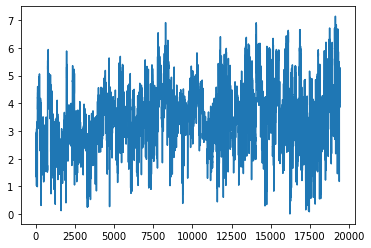

In [87]:
data_full['rougher.input.feed_pb'].plot(kind='line');

In [88]:
data_full['rougher.output.concentrate_pb'].median()

7.742580079502529

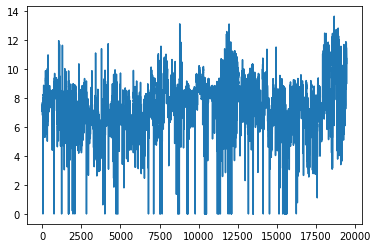

In [89]:
data_full['rougher.output.concentrate_pb'].plot(kind='line');

In [90]:
data_full['primary_cleaner.output.concentrate_pb'].median()

10.142270415359071

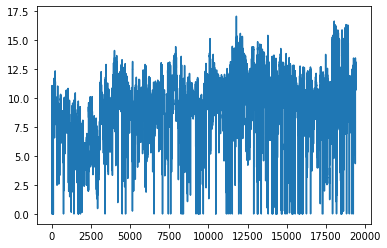

In [91]:
data_full['primary_cleaner.output.concentrate_pb'].plot(kind='line');

In [92]:
data_full['final.output.concentrate_pb'].median()

10.10226350598865

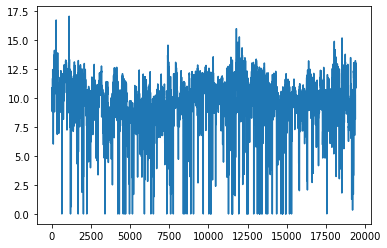

In [93]:
data_full['final.output.concentrate_pb'].plot(kind='line');

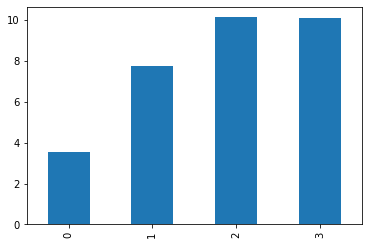

In [94]:
pd.Series([data_full['rougher.input.feed_pb'].median(), \
      data_full['rougher.output.concentrate_pb'].median(), \
     data_full['primary_cleaner.output.concentrate_pb'].median(), \
     data_full['final.output.concentrate_pb'].median()])\
    .plot(kind='bar');

Концентрация свинца постепенно возрастает и на последних двух этапах имеет максимальное значение.

На всех временных графиках прослеживаются нулевые значения, которые скорее всего являются аномалиями, которые мы решили не удалять.

### Сравнение распределений размеров гранул сырья на обучающей и тестовой выборках

Для построения распределений воспользуемся техникой Bootstrap с 1000 выборками. Нам необходимо проверить гипотезу о том, изменился ли размер гранул сырья после разбиения данных на выборки.

In [95]:
samples_A = data_train['rougher.input.feed_size']

In [96]:
samples_B = data_test['rougher.input.feed_size']

In [97]:
data_test.shape[0]/data_train.shape[0]

0.3738780125803944

In [98]:
# фактическая разность средних значений в выборках
AB_difference = samples_A.mean() - samples_B.mean()
AB_difference

4.287101963662181

In [99]:
# объединим выборки 
united_samples = pd.concat([samples_A, samples_B])

In [100]:
alpha = 0.05 #задаем уровень значимости
bootstrap_samples = 1000
count = 0
state = np.random.RandomState(12345)

for i in range(bootstrap_samples):

    # создаем подвыборку
    subsample = united_samples.sample(frac=1, replace=True, random_state=state)
    #print(subsample)
    # разбиваем подвыборки пропорционально соотношению трейна и теста
    subsample_A = subsample[:int(data_train.shape[0])]
    subsample_B = subsample[int(data_train.shape[0]):]
    #print(len(subsample_A))

    # найдем разницу средних
    bootstrap_difference = subsample_A.mean() - subsample_B.mean()
    
    #print(bootstrap_difference)
    # если разница не меньше фактической, увеличиваем счётчик
    if bootstrap_difference > AB_difference:
        count += 1

# p-value равно доле превышений значений
pvalue = 1. * count / bootstrap_samples
print('p-value =', pvalue)

if pvalue < alpha:
    print("Отвергаем нулевую гипотезу: скорее всего, средние отличаются")
else:
    print("Не получилось отвергнуть нулевую гипотезу: скорее всего, средние не отличаются")

p-value = 0.0
Отвергаем нулевую гипотезу: скорее всего, средние отличаются


Так как преподаватель сказал, что нам не нужно статистическая значимость схожести распределений, то оценим схожесть приблизительно, графическим спосоом и изучив основные данные:

In [101]:
data_train['rougher.input.feed_size'].describe()

count    14149.000000
mean        60.239856
std         23.005310
min          9.659576
25%         48.966751
50%         55.269784
75%         66.007526
max        484.967466
Name: rougher.input.feed_size, dtype: float64

In [102]:
data_test['rougher.input.feed_size'].describe()

count    5290.000000
mean       55.952754
std        19.080334
min         0.046369
25%        43.906504
50%        50.846843
75%        62.451165
max       392.494040
Name: rougher.input.feed_size, dtype: float64

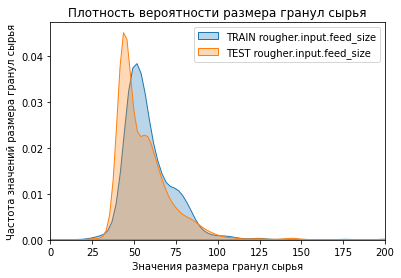

In [103]:
sns.kdeplot(data_train['rougher.input.feed_size'], shade=True,\
            label = 'TRAIN rougher.input.feed_size', alpha=.3)
sns.kdeplot(data_test['rougher.input.feed_size'], shade=True,\
            label = 'TEST rougher.input.feed_size', alpha=.3)
plt.show
plt.ylabel('Частота значений размера гранул сырья')
plt.xlabel('Значения размера гранул сырья')
plt.title('Плотность вероятности размера гранул сырья')
plt.legend()
plt.xlim([0,200]);

Анализируя средние значения, ско, медианы и графики плотностей вероятности размера гранул сырья, можно сказать, что примерно они одинаковы, несмотря на отсутствие статистической схожести распределений. 

### Исследование суммарной концентрации всех веществ на разных стадиях: в сырье, в черновом и финальном концентратах

Для расчета суммарной концентрации веществ в сырье сложим значения следующих признаков:<br>
rougher.input.feed_ag, rougher.input.feed_pb, rougher.input.feed_au

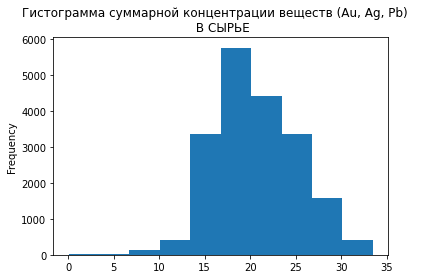

In [104]:
# гистограмма суммарной концентрации в сырье
(data_full['rougher.input.feed_au'] + \
data_full['rougher.input.feed_ag'] + \
data_full['rougher.input.feed_pb']).plot(kind='hist', \
   title='Гистограмма суммарной концентрации веществ (Au, Ag, Pb)\
   \n В СЫРЬЕ');

Количество аномальных нулевых концентраций:

In [105]:
len(data_full.query('(`rougher.input.feed_au` + \
`rougher.input.feed_ag` + `rougher.input.feed_pb`) == 0'))

0

Для расчета суммарной концентрации веществ в черновом концентрате сложим  значения следующих признаков:<br>
rougher.output.concentrate_ag, rougher.output.concentrate_pb, rougher.output.concentrate_au

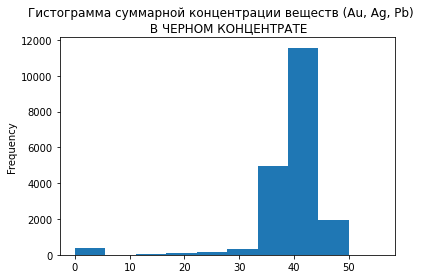

In [106]:
# гистограмма суммарной концентрации в черновом концентрате
(data_full['rougher.output.concentrate_au'] + \
data_full['rougher.output.concentrate_ag'] + \
data_full['rougher.output.concentrate_pb']).plot(kind='hist',\
   title='Гистограмма суммарной концентрации веществ (Au, Ag, Pb)\
   \n В ЧЕРНОМ КОНЦЕНТРАТЕ');

Количество аномальных нулевых концентраций:

In [107]:
len(data_full.query('(`rougher.output.concentrate_au` + \
`rougher.output.concentrate_ag` + `rougher.output.concentrate_pb`) == 0'))

394

In [108]:
data_full.query('(`rougher.output.concentrate_au` + \
`rougher.output.concentrate_ag` + `rougher.output.concentrate_pb`) == 0').index  # индексы нулевых концентраций

Int64Index([   45,    46,    47,    48,    49,    50,    51,   759,  1243,
             1682,
            ...
            15599, 15600, 15617, 15618, 15619, 15620, 15621, 15622, 15623,
            15624],
           dtype='int64', length=394)

Для расчета суммарной концентрации веществ в финальном концентрате сложим  значения следующих признаков:<br>
rougher.input.feed_ag, rougher.input.feed_pb, rougher.input.feed_au

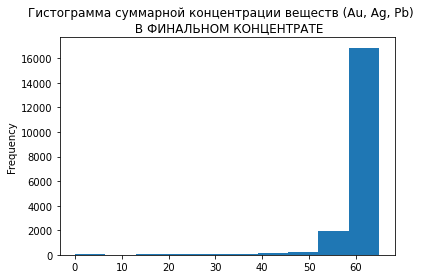

In [109]:
# гистограмма суммарной концентрации в финальном концентрате
(data_full['final.output.concentrate_au'] + \
data_full['final.output.concentrate_ag'] + \
data_full['final.output.concentrate_pb']).plot(kind='hist',\
   title='Гистограмма суммарной концентрации веществ (Au, Ag, Pb)\
   \n В ФИНАЛЬНОМ КОНЦЕНТРАТЕ');

Количество аномальных нулевых концентраций:

In [110]:
len(data_full.query('(`final.output.concentrate_au` + \
`final.output.concentrate_ag` + `final.output.concentrate_pb`) == 0'))

98

In [111]:
data_full.query('(`final.output.concentrate_au` + \
`final.output.concentrate_ag` + `final.output.concentrate_pb`) == 0').index  # индексы нулевых концентраций

Int64Index([  644,  1193,  1194,  1195,  1196,  1682,  2019,  2020,  2236,
             3394,  3395,  3396,  3397,  3400,  4215,  4314,  4564,  4652,
             4653,  4712,  4964,  5150,  5151,  5915,  6327,  6488,  7342,
             7343,  7344,  7585,  7586,  7587,  7588,  7589,  7759,  7760,
             8404,  8491,  8492,  8636,  8637,  8638,  8639,  8874,  9050,
             9670,  9671,  9672,  9673,  9674, 10026, 10138, 10139, 10176,
            11285, 11504, 11518, 11519, 11520, 11539, 11540, 11940, 12460,
            12478, 12546, 12547, 12895, 12896, 13131, 13254, 13257, 13274,
            13364, 13438, 13439, 13697, 13781, 14082, 14083, 14358, 14359,
            14360, 14639, 14733, 14734, 14735, 14736, 14737, 14738, 14742,
            14745, 14746, 14938, 14951, 14952, 15183, 15184, 15310],
           dtype='int64')

### Промежуточные выводы

Проведен анализ данных:
- проанализировано изменение концентрации металлов (Au, Ag, Pb) на различных этапах очистки; концентрация золота логично увеличивается от начального этапа к финальному;
- сравнение распределений размеров гранул сырья для обучающей и тестовой выборок показало их статистически значимое отличие (использовался метод Bootstrap для А/В тестирования), в то же время в целом средние и огибающие распределения повторяют друг друга с допустимой погрешностью (какой именно - этого преподаватель мне не сказал), поэтому принято решение о схожести распределений;
- исследована суммарная концентрация веществ на различных этапах: средние значения свидетельствуют о росте суммарной концентрации, в то же время присутствуют случаи нулевых значений суммарной концентрации, объяснить которые не представляется возможным (либо это особенность техпроцесса, либо аномалии), принято решение их не удалять.

## Модель

### Функция для вычисления итоговой метрики sMAPE

In [112]:
def calc_sMAPE(target, predict):
    sMAPE = ((((np.abs(target - predict)) * 2)/ (np.abs(target) + np.abs(predict))).sum()) * 100 / len(target) 
    return sMAPE

In [113]:
def aggregate_sMAPE(rougher_sMAPE, final_sMAPE):
    sMAPE= 0.25 * rougher_sMAPE + 0.75 * final_sMAPE
    return sMAPE

### Обучение моделей и оценка их качества кросс-валидацией

В качестве моделей будем использовать изученные ранее модели линейной регрессии, решающего дерева и случайного леса.<br>
Разделим процесс обучения на два этапа: обучение моделей для этапа флотации и обучение моделей для этапа очистки.

#### Обучение моделей для этапа флотации

Ниже рассмотрим методы GridSearchCV и cross_val_score, а также самописную кросс-валидацию.

Зададим общие паарметры перед исследованием:

In [114]:
CV = 5 # задаем число блоков кросс-валидации
sample_size = int(len(features_floatation_train)/CV)  # зададим размер блока
features_floatation_train = features_floatation_train.reset_index(drop=True) # сбросим индексы
target_floatation_train = target_floatation_train.reset_index(drop=True) # сбросим индексы

**Решающее дерево**

In [115]:
parametrs = { 'max_depth': range (1, 18, 2),
              'random_state': [12345]
            }

In [116]:
model = DecisionTreeRegressor()

In [117]:
scorer = make_scorer(calc_sMAPE, greater_is_better=False)
GSCV = GridSearchCV(model, parametrs, cv = CV, scoring = scorer)

In [118]:
%%time
GSCV.fit(features_floatation_train, target_floatation_train)

CPU times: user 8.44 s, sys: 11.3 ms, total: 8.46 s
Wall time: 8.48 s


GridSearchCV(cv=5, estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': range(1, 18, 2), 'random_state': [12345]},
             scoring=make_scorer(calc_sMAPE, greater_is_better=False))

In [119]:
GSCV.best_params_

{'max_depth': 3, 'random_state': 12345}

In [120]:
rougher_sMAPE = np.abs(GSCV.best_score_)
rougher_sMAPE

12.102291293681215

In [121]:
randm_src = RandomizedSearchCV(estimator=model, param_distributions = parametrs,
                               cv = CV, n_iter = 7, scoring = scorer)

In [122]:
%%time
randm_src.fit(features_floatation_train, target_floatation_train)

CPU times: user 7.65 s, sys: 1.41 ms, total: 7.65 s
Wall time: 7.67 s


RandomizedSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_iter=7,
                   param_distributions={'max_depth': range(1, 18, 2),
                                        'random_state': [12345]},
                   scoring=make_scorer(calc_sMAPE, greater_is_better=False))

In [123]:
randm_src.best_score_

-12.102291293681215

In [124]:
randm_src.best_params_

{'random_state': 12345, 'max_depth': 3}

In [125]:
sMAPE = []
def objective_cv(trial):
    
    depth = trial.suggest_int('max_depth', 1, 18, log=True)
    
    for i in range(0, len(features_floatation_train), sample_size):
    
        # массив из индексов для валидационного блока
        valid_indexes = list(range(i, i+sample_size))
        # массив из индексов для обучающей выборки
        train_indexes = list(range(0, i)) + list(range(i+sample_size,len(features_floatation_train))) 

        # разбиаем переменные features и target на выборки features_train, target_train, 
        # features_valid, target_valid
        features_train = features_floatation_train[features_floatation_train.index.isin(train_indexes)]
        target_train = target_floatation_train[target_floatation_train.index.isin(train_indexes)]
        features_valid = features_floatation_train[features_floatation_train.index.isin(valid_indexes)]
        target_valid = target_floatation_train[target_floatation_train.index.isin(valid_indexes)]

        dtr_model = DecisionTreeRegressor(max_depth=depth, random_state=12345)
        dtr_model.fit(features_train, target_train)
        predicted_valid = dtr_model.predict(features_valid)

        sMAPE.append(calc_sMAPE(target_valid, predicted_valid))
    
    return np.mean(sMAPE)

study = optuna.create_study(direction='minimize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study.optimize(objective_cv, n_trials=10)
#study.best_params
#study.best_trials
# study.best_value

study.best_params, study.best_value

[I 2023-03-08 15:32:39,860] A new study created in memory with name: no-name-217fb994-fb50-48c1-b5ae-5577684172c5


({'max_depth': 1}, 11.829260415428154)

Теперь то же, но с помощью самописной кросс-валидации:

In [126]:
rougher_sMAPE = 0
best_depth = 0
sMAPE = []
score_sMAPE = []

for depth in range(1, 18, 2):
    
    for i in range(0, len(features_floatation_train), sample_size):
    
        # массив из индексов для валидационного блока
        valid_indexes = list(range(i, i+sample_size))
        # массив из индексов для обучающей выборки
        train_indexes = list(range(0, i)) + list(range(i+sample_size,len(features_floatation_train))) 

        # разбиаем переменные features и target на выборки features_train, target_train, 
        # features_valid, target_valid
        features_train = features_floatation_train[features_floatation_train.index.isin(train_indexes)]
        target_train = target_floatation_train[target_floatation_train.index.isin(train_indexes)]
        features_valid = features_floatation_train[features_floatation_train.index.isin(valid_indexes)]
        target_valid = target_floatation_train[target_floatation_train.index.isin(valid_indexes)]
   
        model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
        model = model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)

        sMAPE.append(calc_sMAPE(target_valid, predicted_valid))

    # среднее качество модели  
    score = np.mean(sMAPE)
    score_sMAPE.append(score)

    if score <= np.min(score_sMAPE):
        rougher_sMAPE = score
        best_depth = depth
        
    sMAPE = []
    
rougher_sMAPE, best_depth

(10.770824486952678, 5)

Теперь то же, но с помощью cross_val_score:

In [127]:
rougher_sMAPE = 0
best_depth = 0
score_sMAPE = []
scorer = make_scorer(calc_sMAPE, greater_is_better=False)

for depth in range(1, 18, 2):
    model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
    
    # среднее качество модели  
    sMAPE = abs(cross_val_score(model, features_floatation_train, \
                                target_floatation_train, cv=CV, scoring=scorer).mean())
    score_sMAPE.append(sMAPE)

    if sMAPE <= np.min(score_sMAPE):
        rougher_sMAPE = sMAPE
        best_depth = depth
    
rougher_sMAPE, best_depth

(12.102291293681215, 3)

Таким образом, подходящим вариантом с минимальной метрикой rougher_sMAPE ~ 10.8 % является модель DecisionTreeRegressor(random_state=12345, max_depth=5)

**Случайный лес**

Метод GridSearch

In [128]:
parametrs = { 'max_depth': range (1, 6, 2),
             'n_estimators': range (1, 20, 9),
              'random_state': [12345]
            }

In [129]:
model = RandomForestRegressor()

In [130]:
scorer = make_scorer(calc_sMAPE, greater_is_better=False)
GSCV = GridSearchCV(model, parametrs, cv = CV, scoring = scorer)

In [131]:
GSCV.fit(features_floatation_train, target_floatation_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': range(1, 6, 2),
                         'n_estimators': range(1, 20, 9),
                         'random_state': [12345]},
             scoring=make_scorer(calc_sMAPE, greater_is_better=False))

In [132]:
GSCV.best_params_

{'max_depth': 3, 'n_estimators': 19, 'random_state': 12345}

In [133]:
rougher_sMAPE = np.abs(GSCV.best_score_)
rougher_sMAPE

11.602961996757935

Теперь то же, но с помощью самописной кросс-валидации:

In [134]:
rougher_sMAPE = 0
best_depth = 0
best_est = 0
sMAPE = []
score_sMAPE = []

for est in range(1, 20, 9):
    for depth in range(1, 6, 2):
        for i in range(0, len(features_floatation_train), sample_size):
    
            # массив из индексов для валидационного блока
            valid_indexes = list(range(i, i+sample_size))
            # массив из индексов для обучающей выборки
            train_indexes = list(range(0, i)) + list(range(i+sample_size,len(features_floatation_train))) 

            # разбиаем переменные features и target на выборки features_train, target_train, 
            # features_valid, target_valid
            features_train = features_floatation_train[features_floatation_train.index.isin(train_indexes)]
            target_train = target_floatation_train[target_floatation_train.index.isin(train_indexes)]
            features_valid = features_floatation_train[features_floatation_train.index.isin(valid_indexes)]
            target_valid = target_floatation_train[target_floatation_train.index.isin(valid_indexes)]

            model = RandomForestRegressor(random_state=12345, max_depth=depth, n_estimators=est)
            model = model.fit(features_train, target_train)
            predicted_valid = model.predict(features_valid)

            sMAPE.append(calc_sMAPE(target_valid, predicted_valid))

        # среднее качество модели  
        score = np.mean(sMAPE)
        score_sMAPE.append(score)
        
        if score <= np.min(score_sMAPE):
            rougher_sMAPE = score
            best_depth = depth
            best_est = est
        
        sMAPE = []
    
rougher_sMAPE, best_depth, best_est

(9.959003181662803, 5, 10)

Теперь то же, но с помощью cross_val_score:

In [135]:
rougher_sMAPE = 0
best_depth = 0
best_est = 0
score_sMAPE = []
scorer = make_scorer(calc_sMAPE, greater_is_better=False)

for depth in range(1, 6, 2):
    for est in range(1, 20, 9):
        model = RandomForestRegressor(random_state=12345, max_depth=depth, n_estimators=est)

        # среднее качество модели  
        sMAPE = abs(cross_val_score(model, features_floatation_train, target_floatation_train,\
                                    cv=CV, scoring=scorer).mean())
        score_sMAPE.append(sMAPE)

        if sMAPE <= np.min(score_sMAPE):
            rougher_sMAPE = sMAPE
            best_depth = depth
            best_est = est
    
rougher_sMAPE, best_depth, best_est

(11.602961996757935, 3, 19)

Подходящим вариантом с минимальной метрикой sMAPE ~ 9.96 % является модель RandomForestRegressor(random_state=12345, max_depth=5, n_estimators=10)

**Линейная регрессия**

Метод GridSearch

In [136]:
parametrs = {}

In [137]:
model = LinearRegression()

In [138]:
scorer = make_scorer(calc_sMAPE, greater_is_better=False)
GSCV = GridSearchCV(model, parametrs, cv = CV, scoring = scorer)

In [139]:
GSCV.fit(features_floatation_train, target_floatation_train)

GridSearchCV(cv=5, estimator=LinearRegression(), param_grid={},
             scoring=make_scorer(calc_sMAPE, greater_is_better=False))

In [140]:
GSCV.best_params_

{}

In [141]:
rougher_sMAPE = np.abs(GSCV.best_score_)
rougher_sMAPE

12.472324262880548

Самописный вариант кросс-валидации:

In [142]:
sMAPE = []
    
for i in range(0, len(features_floatation_train), sample_size):

    # массив из индексов для валидационного блока
    valid_indexes = list(range(i, i+sample_size))
    # массив из индексов для обучающей выборки
    train_indexes = list(range(0, i)) + list(range(i+sample_size,len(features_floatation_train))) 

    # разбиаем переменные features и target на выборки features_train, target_train, features_valid, target_valid
    features_train = features_floatation_train[features_floatation_train.index.isin(train_indexes)]
    target_train = target_floatation_train[target_floatation_train.index.isin(train_indexes)]
    features_valid = features_floatation_train[features_floatation_train.index.isin(valid_indexes)]
    target_valid = target_floatation_train[target_floatation_train.index.isin(valid_indexes)]

    model = LinearRegression()
    model = model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)

    sMAPE.append(calc_sMAPE(target_valid, predicted_valid))

# среднее качество модели  
rougher_sMAPE = np.mean(sMAPE)
rougher_sMAPE

11.985235638314608

Теперь то же, но с помощью cross_val_score:

In [143]:
scorer = make_scorer(calc_sMAPE, greater_is_better=False)
model = LinearRegression()

# среднее качество модели  
rougher_sMAPE = abs(cross_val_score(model, features_floatation_train, target_floatation_train,\
                            cv=CV, scoring=scorer).mean())
rougher_sMAPE

12.472324262880548

Минимальная метрика для модели LinearRegression ~ 12.0 %.

Проверим теперь заранее подготовленные выборки для модели LinearRegression (без коррелирующих признаков).

In [144]:
sMAPE = []

for i in range(0, len(features_floatation_train_linear), sample_size):

    # массив из индексов для валидационного блока
    valid_indexes = list(range(i, i+sample_size))
    # массив из индексов для обучающей выборки
    train_indexes = list(range(0, i)) + list(range(i+sample_size,len(features_floatation_train_linear))) 

    # разбиаем переменные features и target на выборки features_train, target_train, features_valid, target_valid
    features_train = features_floatation_train_linear[features_floatation_train_linear.index.isin(train_indexes)]
    target_train = target_floatation_train[target_floatation_train.index.isin(train_indexes)]
    features_valid = features_floatation_train_linear[features_floatation_train_linear.index.isin(valid_indexes)]
    target_valid = target_floatation_train[target_floatation_train.index.isin(valid_indexes)]

    model = LinearRegression()
    model = model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)

    sMAPE.append(calc_sMAPE(target_valid, predicted_valid))

# среднее качество модели  
rougher_sMAPE = np.mean(sMAPE)
rougher_sMAPE

10.472953015710106

Теперь то же, но с помощью cross_val_score:

In [145]:
scorer = make_scorer(calc_sMAPE, greater_is_better=False)
model = LinearRegression()

# среднее качество модели  
rougher_sMAPE = abs(cross_val_score(model, features_floatation_train_linear, \
                            target_floatation_train, cv=CV, scoring=scorer).mean())
rougher_sMAPE

11.644312640058168

Метод GridSearch

In [146]:
parametrs = {}

In [147]:
model = LinearRegression()

In [148]:
scorer = make_scorer(calc_sMAPE, greater_is_better=False)
GSCV = GridSearchCV(model, parametrs, cv = CV, scoring = scorer)

In [149]:
GSCV.fit(features_floatation_train_linear, target_floatation_train)

GridSearchCV(cv=5, estimator=LinearRegression(), param_grid={},
             scoring=make_scorer(calc_sMAPE, greater_is_better=False))

In [150]:
GSCV.best_params_

{}

In [151]:
rougher_sMAPE = np.abs(GSCV.best_score_)
rougher_sMAPE

11.644312640058168

С учетом устранения эффекта мультиколлинеарности удалось снизить метрику sMAPE с 12 до 10.5 %.

Таким образом, наилучший результат rougher_sMAPE ~ 9.96 % достигнут с помощью модели RandomForestRegressor(random_state=12345, max_depth=5, n_estimators=10). Самописная кросс-валидация показала наилучшие резултаты по сравнению методами GridSearchCV и cross_val_score.

In [152]:
rougher_sMAPE = 9.96

#### Обучение моделей для этапа очистки

На данном этапе используем самописную кросс-валидацию для всех моделей.

Задаем общие параметры:

In [153]:
CV = 5
sample_size = int(len(features_clearance_train)/CV)  # зададим размер блока
features_clearance_train = features_clearance_train.reset_index(drop=True) # сбросим индексы
target_clearance_train = target_clearance_train.reset_index(drop=True) # сбросим индексы

**Решающее дерево**

In [154]:
final_sMAPE = 0
best_depth = 0
sMAPE = []
score_sMAPE = []

for depth in range(1, 18, 2):
    
    for i in range(0, len(features_clearance_train), sample_size):
    
        # массив из индексов для валидационного блока
        valid_indexes = list(range(i, i+sample_size))
        # массив из индексов для обучающей выборки
        train_indexes = list(range(0, i)) + list(range(i+sample_size,len(features_clearance_train))) 

        # разбиаем переменные features и target на выборки features_train, target_train,
        # features_valid, target_valid
        features_train = features_clearance_train[features_clearance_train.index.isin(train_indexes)]
        target_train = target_clearance_train[target_clearance_train.index.isin(train_indexes)]
        features_valid = features_clearance_train[features_clearance_train.index.isin(valid_indexes)]
        target_valid = target_clearance_train[target_clearance_train.index.isin(valid_indexes)]

    
        model = DecisionTreeRegressor(random_state=12345, max_depth=depth)
        model = model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)

        sMAPE.append(calc_sMAPE(target_valid, predicted_valid))

    # среднее качество модели  
    score = np.mean(sMAPE)
    score_sMAPE.append(score)

    if score <= np.min(score_sMAPE):
        final_sMAPE = score
        best_depth = depth
        
    sMAPE = []
    
final_sMAPE, best_depth

(9.625761510845635, 1)

**Случайный лес**

In [155]:
final_sMAPE = 0
best_depth = 0
best_est = 0
sMAPE = []
score_sMAPE = []

for depth in range(1, 6, 2):
    for est in range(1, 20, 9):
        for i in range(0, len(features_clearance_train), sample_size):
    
            # массив из индексов для валидационного блока
            valid_indexes = list(range(i, i+sample_size))
            # массив из индексов для обучающей выборки
            train_indexes = list(range(0, i)) + list(range(i+sample_size,len(features_clearance_train))) 

            # разбиаем переменные features и target на выборки features_train, target_train,
            # features_valid, target_valid
            features_train = features_clearance_train[features_clearance_train.index.isin(train_indexes)]
            target_train = target_clearance_train[target_clearance_train.index.isin(train_indexes)]
            features_valid = features_clearance_train[features_clearance_train.index.isin(valid_indexes)]
            target_valid = target_clearance_train[target_clearance_train.index.isin(valid_indexes)]


            model = RandomForestRegressor(random_state=12345, max_depth=depth, n_estimators=est)
            model = model.fit(features_train, target_train)
            predicted_valid = model.predict(features_valid)

            sMAPE.append(calc_sMAPE(target_valid, predicted_valid))

        # среднее качество модели  
        score = np.mean(sMAPE)
        score_sMAPE.append(score)
        
        if score <= np.min(score_sMAPE):
            final_sMAPE = score
            best_depth = depth
            best_est = est
            
        sMAPE = []
    
final_sMAPE, best_depth, best_est

(9.568727519587142, 1, 19)

**Линейная регрессия**

До удаления коррелирующих признаков:

In [156]:
sMAPE = []
    
for i in range(0, len(features_clearance_train), sample_size):

    # массив из индексов для валидационного блока
    valid_indexes = list(range(i, i+sample_size))
    # массив из индексов для обучающей выборки
    train_indexes = list(range(0, i)) + list(range(i+sample_size,len(features_clearance_train))) 

    # разбиаем переменные features и target на выборки features_train, target_train, features_valid, target_valid
    features_train = features_clearance_train[features_clearance_train.index.isin(train_indexes)]
    target_train = target_clearance_train[target_clearance_train.index.isin(train_indexes)]
    features_valid = features_clearance_train[features_clearance_train.index.isin(valid_indexes)]
    target_valid = target_clearance_train[target_clearance_train.index.isin(valid_indexes)]


    model = LinearRegression()
    model = model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)

    sMAPE.append(calc_sMAPE(target_valid, predicted_valid))

# среднее качество модели  
final_sMAPE = np.mean(sMAPE)
final_sMAPE

9.603058411054574

После удаления коррелирующих признаков:

In [157]:
sMAPE = []
    
for i in range(0, len(features_clearance_train_linear), sample_size):

    # массив из индексов для валидационного блока
    valid_indexes = list(range(i, i+sample_size))
    # массив из индексов для обучающей выборки
    train_indexes = list(range(0, i)) + list(range(i+sample_size,len(features_clearance_train_linear))) 

    # разбиаем переменные features и target на выборки features_train, target_train, features_valid, target_valid
    features_train = features_clearance_train_linear[features_clearance_train_linear.index.isin(train_indexes)]
    target_train = target_clearance_train[target_clearance_train.index.isin(train_indexes)]
    features_valid = features_clearance_train_linear[features_clearance_train_linear.index.isin(valid_indexes)]
    target_valid = target_clearance_train[target_clearance_train.index.isin(valid_indexes)]


    model = LinearRegression()
    model = model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)

    sMAPE.append(calc_sMAPE(target_valid, predicted_valid))

# среднее качество модели  
final_sMAPE = np.mean(sMAPE)
final_sMAPE

9.957675057776013

Результаты исследования показали, что на этапе очистки наилучшее значение метрики final_sMAPE ~ 9.57 обеспечивается моделью RandomForestRegressor(random_state=12345, max_depth=1, n_estimators=19).

Компенсация мультиколлинеарности не обеспечила повышение метрики на этапе очистки.

In [158]:
final_sMAPE = 9.57

Итоговая метрика sMAPE:

In [159]:
aggregate_sMAPE(rougher_sMAPE, final_sMAPE)

9.6675

In [160]:
final_sMAPE = 0
best_depth = 0
best_est = 0
sMAPE = []
score_sMAPE = []

for depth in range(1, 9, 2):
    for est in range(1, 20, 9):
        for i in range(0, len(features_clearance_train), sample_size):
    
            # массив из индексов для валидационного блока
            valid_indexes = list(range(i, i+sample_size))
            # массив из индексов для обучающей выборки
            train_indexes = list(range(0, i)) + list(range(i+sample_size,len(features_clearance_train))) 

            # разбиаем переменные features и target на выборки features_train, target_train,
            # features_valid, target_valid
            features_train = features_clearance_train[features_clearance_train.index.isin(train_indexes)]
            target_train = target_clearance_train[target_clearance_train.index.isin(train_indexes)]
            features_valid = features_clearance_train[features_clearance_train.index.isin(valid_indexes)]
            target_valid = target_clearance_train[target_clearance_train.index.isin(valid_indexes)]


            model = CatBoostRegressor(random_state=12345, max_depth=depth, n_estimators=est, verbose=False)
            model = model.fit(features_train, target_train)
            predicted_valid = model.predict(features_valid)

            sMAPE.append(calc_sMAPE(target_valid, predicted_valid))

        # среднее качество модели  
        score = np.mean(sMAPE)
        score_sMAPE.append(score)
        
        if score <= np.min(score_sMAPE):
            final_sMAPE = score
            best_depth = depth
            best_est = est
            
        sMAPE = []
    
final_sMAPE, best_depth, best_est

(9.495575449974966, 1, 19)

In [161]:
final_sMAPE = 0
best_depth = 0
best_est = 0
sMAPE = []
score_sMAPE = []

for depth in range(1, 9, 2):
    for est in range(1, 20, 9):
        for i in range(0, len(features_clearance_train), sample_size):
    
            # массив из индексов для валидационного блока
            valid_indexes = list(range(i, i+sample_size))
            # массив из индексов для обучающей выборки
            train_indexes = list(range(0, i)) + list(range(i+sample_size,len(features_clearance_train))) 

            # разбиаем переменные features и target на выборки features_train, target_train,
            # features_valid, target_valid
            features_train = features_clearance_train[features_clearance_train.index.isin(train_indexes)]
            target_train = target_clearance_train[target_clearance_train.index.isin(train_indexes)]
            features_valid = features_clearance_train[features_clearance_train.index.isin(valid_indexes)]
            target_valid = target_clearance_train[target_clearance_train.index.isin(valid_indexes)]


            model = Ridge(alpha=0.7)
            model = model.fit(features_train, target_train)
            predicted_valid = model.predict(features_valid)

            sMAPE.append(calc_sMAPE(target_valid, predicted_valid))

        # среднее качество модели  
        score = np.mean(sMAPE)
        score_sMAPE.append(score)
        
        if score <= np.min(score_sMAPE):
            final_sMAPE = score
            best_depth = depth
            best_est = est
            
        sMAPE = []
    
final_sMAPE, best_depth, best_est

(9.601977169796378, 7, 19)

In [162]:
final_sMAPE = 0
best_depth = 0
best_est = 0
sMAPE = []
score_sMAPE = []

for depth in range(1, 9, 2):
    for est in range(1, 20, 9):
        for i in range(0, len(features_clearance_train), sample_size):
    
            # массив из индексов для валидационного блока
            valid_indexes = list(range(i, i+sample_size))
            # массив из индексов для обучающей выборки
            train_indexes = list(range(0, i)) + list(range(i+sample_size,len(features_clearance_train))) 

            # разбиаем переменные features и target на выборки features_train, target_train,
            # features_valid, target_valid
            features_train = features_clearance_train[features_clearance_train.index.isin(train_indexes)]
            target_train = target_clearance_train[target_clearance_train.index.isin(train_indexes)]
            features_valid = features_clearance_train[features_clearance_train.index.isin(valid_indexes)]
            target_valid = target_clearance_train[target_clearance_train.index.isin(valid_indexes)]


            model = Lasso(alpha=0.7)
            model = model.fit(features_train, target_train)
            predicted_valid = model.predict(features_valid)

            sMAPE.append(calc_sMAPE(target_valid, predicted_valid))

        # среднее качество модели  
        score = np.mean(sMAPE)
        score_sMAPE.append(score)
        
        if score <= np.min(score_sMAPE):
            final_sMAPE = score
            best_depth = depth
            best_est = est
            
        sMAPE = []
    
final_sMAPE, best_depth, best_est

(9.344486616079239, 7, 19)

In [163]:
final_sMAPE = 0
best_depth = 0
best_est = 0
sMAPE = []
score_sMAPE = []

for depth in range(1, 9, 2):
    for est in range(1, 20, 9):
        for i in range(0, len(features_clearance_train), sample_size):
    
            # массив из индексов для валидационного блока
            valid_indexes = list(range(i, i+sample_size))
            # массив из индексов для обучающей выборки
            train_indexes = list(range(0, i)) + list(range(i+sample_size,len(features_clearance_train))) 

            # разбиаем переменные features и target на выборки features_train, target_train,
            # features_valid, target_valid
            features_train = features_clearance_train[features_clearance_train.index.isin(train_indexes)]
            target_train = target_clearance_train[target_clearance_train.index.isin(train_indexes)]
            features_valid = features_clearance_train[features_clearance_train.index.isin(valid_indexes)]
            target_valid = target_clearance_train[target_clearance_train.index.isin(valid_indexes)]


            model = ElasticNet(alpha=0.7)
            model = model.fit(features_train, target_train)
            predicted_valid = model.predict(features_valid)

            sMAPE.append(calc_sMAPE(target_valid, predicted_valid))

        # среднее качество модели  
        score = np.mean(sMAPE)
        score_sMAPE.append(score)
        
        if score <= np.min(score_sMAPE):
            final_sMAPE = score
            best_depth = depth
            best_est = est
            
        sMAPE = []
    
final_sMAPE, best_depth, best_est

(9.290741229586498, 7, 19)

### Выбoр лучшей модели и её проверка на тестовой выборке

С учетом выбранных моделей определим тестовые значения метрик.

Этап флотации:

In [164]:
model = RandomForestRegressor(random_state=12345, max_depth=5, n_estimators=10)
model.fit(features_floatation_train, target_floatation_train)
predicted = model.predict(features_floatation_test)
rougher_sMAPE = calc_sMAPE(target_floatation_test, predicted)
rougher_sMAPE

8.982860139352812

Этап очитски:

In [165]:
model = RandomForestRegressor(random_state=12345, max_depth=1, n_estimators=19)
model.fit(features_clearance_train, target_clearance_train)
predicted = model.predict(features_clearance_test)
final_sMAPE = calc_sMAPE(target_clearance_test, predicted)
final_sMAPE

9.332465823899122

Итоговая метрика sMAPE:

In [166]:
aggregate_sMAPE(rougher_sMAPE, final_sMAPE)

9.245064402762544

Проверим адекватность модели:

In [167]:
# создаем объект dummy со стратегией заполнения средним
dummy_reg = DummyRegressor(strategy="mean")
# обучаем на трейне
dummy_reg.fit(features_floatation_train, target_floatation_train)

# считаем метрики для dummyregressor
dummy_rougher_sMAPE = calc_sMAPE(target_floatation_test, dummy_reg.predict(features_floatation_test))
dummy_final_sMAPE = calc_sMAPE(target_clearance_test, dummy_reg.predict(features_clearance_test))

# считаем итоговую метрику
aggregate_sMAPE(dummy_rougher_sMAPE, dummy_final_sMAPE)

17.82366134541921

Значение метрики намного больше рассчитанного, что подтверждает адекватность выбранной модели.

### Промежуточные выводы

- созданы функция расчета метрики sMAPE и итоговой метрики sMAPE;
- в качестве моделей использовались модель решающее дерево, случайный лес и линейная регрессия;
- модель линейной регрессии обучалась на двух подготовленных наборах признаков: с корреляцией и без корреляции, на этапе флотации использование выборки без мультиколлинеарных признаков обеспечило улучшение метрики на 1,5 %; на этапе очистки результат наоборот был незначительно хуже (на 0.35 метрики), в целом, модель линейной регрессии, обученная на неколлинеарных признаках лишь незначительно уступала модели случайный лес;
- выбрана лучшая модель для каждого из этапов: для флотации - модель RandomForestRegressor(random_state=12345, max_depth=5, n_estimators=10) с метрикой rougher_sMAPE = 9.96 %, для этапа очистки -  модель model = RandomForestRegressor(random_state=12345, max_depth=1, n_estimators=19) с метрикой final_sMAPE = 9.57 %, итоговая метрика sMAPE = 9.67 %;
- тетсирование модели показало следующие результаты: rougher_sMAPE = 8.98 %; final_sMAPE = 9.33 %, итоговая метрика sMAPE = 9.24 %;

## Общий вывод

**Целью настоящего проекта** являлась подготовка прототипа модели машинного обучения для компании «Цифры» для предсказания коэффициента восстановления золота из золотосодержащей руды. В распоряжении были данные с параметрами добычи и очистки. Для оценки моделей использовалась метрика sMAPE («симметричное среднее абсолютное процентное отклонение»).

**Для этого на первом этапе проведена загрузка, изучение и преобработка данных:**
- по условию даны 3 датасета: общий и тренировочный и тестовый, полученные из общего, с пропусками (4481 в общем датасете), но без дубликатов;
- расчет эффективности обогащения проведен верно,
- по признакам, приведенным в тестовой выборке установлены нецелевые признаки, которые можно использовать для обучения моделей;
- в ходе предобработки данных выявлены, но не удалены аномалии в связи с отсутствием информации о техпроцессе, устранены все пропуски методом заполнения предыдущим значением, сформированы тренировочная и тестовая выборки с общим набором признаков, выборки удален не информативный столбец date, выделены нецелевые и целевые признаки для тренировочной и тестовой выборок отдельных этапов, установлена мультиколлинеарность признаков, в связи с чем сформированы дополнительные тренировочная и тестовая выборки для исследования модели линейной регрессии, проведено масштабирование нецелевых признаков для всех подготовленных выборок.

**На втором этапе проведен анализ данных:**

- проанализировано изменение концентрации металлов (Au, Ag, Pb) на различных этапах очистки; концентрация золота логично увеличивается от начального этапа к финальному;
- сравнение распределений размеров гранул сырья для обучающей и тестовой выборок показало их статистически значимое отличие (использовался метод Bootstrap для А/В тестирования), в то же время в целом средние и огибающие распределения повторяют друг друга с допустимой погрешностью (какой именно - этого преподаватель мне не сказал), поэтому принято решение о схожести распределений;
- исследована суммарная концентрация веществ на различных этапах: средние значения свидетельствуют о росте суммарной концентрации, в то же время присутствуют случаи нулевых значений суммарной концентрации, объяснить которые не представляется возможным (либо это особенность техпроцесса, либо аномалии), принято решение их не удалять.

**На третьем этапе проведено исследование моделей и тестирование выбранной лучшей модели:**
- созданы функция расчета метрики sMAPE и итоговой метрики sMAPE;
- в ходе исследования использовались модель решающее дерево, случайный лес и линейная регрессия;
- подбор гиперпараметров производился с помощью кросс-валидации;
- модель линейной регрессии обучалась на двух подготовленных наборах признаков: с корреляцией и без корреляции, на этапе флотации использование выборки без мультиколлинеарных признаков обеспечило улучшение метрики на 1,5 %;  на этапе очистки результат наоборот был незначительно хуже (на 0.35 метрики), в целом, модель линейной регрессии, обученная на неколлинеарных признаках лишь незначительно уступала модели случайный лес;
- выбрана лучшая модель для каждого из этапов: для флотации - модель RandomForestRegressor(random_state=12345, max_depth=5, n_estimators=10) с метрикой rougher_sMAPE = 9.96 %, для этапа очистки - модель model = RandomForestRegressor(random_state=12345, max_depth=1, n_estimators=19) с метрикой final_sMAPE = 9.57 %, итоговая метрика sMAPE = 9.67 %;
- тестирование модели показало следующие результаты: rougher_sMAPE = 8.98 %; final_sMAPE = 9.33 %, итоговая метрика sMAPE = 9.24 %;
- проверена адекватность выбранной модели с помощью метода dummyregressor() со стратегией заполнения средним.
    
   Таким образом, в ходе выполнения проекта приобрели умение использования техники кросс-валидации для оценки качества различных моделей и выбрали прототип модели, которому соответствует минимальная метрика sMAPE на каждом из этапов очистки сырья, что позволит компании "Цифра" обеспечить качественный прогноз восстановления золота из золотосодержащей руды. 

## Вывод для начальства

По имеющимся данным с параметрами добычи и очистки золосодержащей руды и теоретической информации о техпроцессе подготовлен прототип модели машинного обучения для предсказания коэффициента восстановления золота из золотосодержащей руды. В качестве критерия оценки качества моделей использовалась метрика sMAPE («симметричное среднее абсолютное процентное отклонение»), минимизация которой обеспечивает улучшение предсказания коэффициента восстановления золота из золотосодержащей руды. 

Для этапа флотации выбрана модель RandomForestRegressor(random_state=12345, max_depth=5, n_estimators=10) с метрикой rougher_sMAPE = 8.98 %.
Для этапа очистки выбрана модель RandomForestRegressor(random_state=12345, max_depth=1, n_estimators=19) с метрикой final_sMAPE = 9.33 %. 
Итоговая метрика sMAPE = 9.24 %.